In this notebook, I'll go through a full example of using BPReveal to analyze some chip-nexus data. These are the same data that were used in our original paper: Avsec, Ž., Weilert, M., Shrikumar, A. et al. Base-resolution models of transcription-factor binding reveal soft motif syntax. Nat Genet 53, 354–366 (2021). https://doi.org/10.1038/s41588-021-00782-6

You can download the data from https://zenodo.org/record/3371216#.Y0muwFLMKAQ , but be aware that it's 30 GB of data. 
I (Charles McAnany) also have a local copy at Stowers, so if you're at Stowers, just let me know and I'll point you in the right direction. 
I've copied the idr-optimal-set.summit.bed files and the counts.neg.bw and counts.pos.bw files from the downloaded data into my working directory. 

# Setup
Here, I'm just importing stuff and configuring global variables.
This is the section you'll probably want to adjust if you want to work through this tutorial yourself.
In particular, you'll want to change BASE_DIRECTORY, WORKING_DIRECTORY, DATA_DIRECTORY, and SLURM_CONFIG.


In [1]:
# This is specific to running the job on teak (my workstation) since I need to
#add bedtools to my path. You will probably not need to do this.
import os
os.environ["PATH"] = os.environ["PATH"] + ":/n/apps/CentOS7/bin/"
import bpreveal.utils as utils
import bpreveal.tools.plots as bprplots
from bpreveal.tools.slurm import configSlurm, jobsNonGpu, jobsGpu, jobsLocal
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams['figure.dpi'] = 150
import numpy as np

import pybedtools
import pysam
import pyBigWig
import h5py

In [2]:
#Here, I'll set a few constants that will be applicable throughout the project. 

BASE_DIRECTORY="/n/projects/cm2363/bpreveal"
WORKING_DIRECTORY=BASE_DIRECTORY + "/test/oskn"
#The data directory is where I've unpacked the zenodo archive.
DATA_DIRECTORY=WORKING_DIRECTORY + "/bpnet-pub-local"
#I have a little script here that renames motifs in modiscolite. This will be unnecessary with new versions of modiscolite.
SCRIPTS_DIR="/n/projects/cm2363/manuscript-bpreveal/src"
SLURM_CONFIG=configSlurm(["/home/cm2363/.bashrc", "/home/cm2363/.zshrc"], "/n/projects/cm2363/public-bpreveal/4.0.0/env", WORKING_DIRECTORY)
SLURM_CONFIG["gpuType"] = "a100"
GENOME_FASTA="/n/data1/genomes/indexes/mm10/mm10.fa"
TF_NAMES = ["oct4", "sox2", "klf4", "nanog"] #The names of the factors we'll use.
                                             #For consistency, I'm always going 
                                             #to use lowercase. 
TEST_CHROMS = ["chr" + str(x) for x in [1,8,9]]
VAL_CHROMS = ["chr" + str(x) for x in [2,3,4]]
TRAIN_CHROMS = ["chr" + str(x) for x in [5,6,7,10,11,12,13,14,15,16,17,18,19]]

In [3]:
!mkdir -p {WORKING_DIRECTORY}/input
!mkdir -p {WORKING_DIRECTORY}/bed
!mkdir -p {WORKING_DIRECTORY}/json
!mkdir -p {WORKING_DIRECTORY}/logs
!mkdir -p {WORKING_DIRECTORY}/models
!mkdir -p {WORKING_DIRECTORY}/modisco
!mkdir -p {WORKING_DIRECTORY}/pred
!mkdir -p {WORKING_DIRECTORY}/shap
!mkdir -p {WORKING_DIRECTORY}/slurm
!mkdir -p {WORKING_DIRECTORY}/scan
!ls -l {WORKING_DIRECTORY}


total 951
drwxrwxr-x  2 cm2363 domain users  359 Jan  5 11:54 bed
lrwxrwxr-x  1 cm2363 domain users   15 Jun 23  2022 bpnet-pub -> bpnet-pub-local
drwxrwxr-x  5 cm2363 domain users  213 Jan  9 12:41 bpnet-pub-local
drwxrwxr-x  2 cm2363 domain users  126 Jan  5 11:55 input
drwxrwxr-x  2 cm2363 domain users 1480 Jan 10 16:21 json
drwxrwxr-x  2 cm2363 domain users 6824 Jan 10 18:54 logs
drwxrwxr-x  9 cm2363 domain users  439 Jan  5 13:44 models
drwxrwxr-x 10 cm2363 domain users  238 Jan  5 16:20 modisco
-rwxrwxr-x  1 cm2363 domain users  432 Jun  3  2022 notes.txt
drwxrwxr-x  2 cm2363 domain users  963 Jan 10 13:02 pred
drwxrwxr-x  2 cm2363 domain users  921 Jan 10 20:47 scan
drwxrwxr-x  2 cm2363 domain users 1351 Jan 10 15:55 shap
drwxrwxr-x  2 cm2363 domain users  838 Jan 10 16:02 slurm
drwxrwxr-x  2 cm2363 domain users  815 Feb 27  2023 zenodo


In [4]:
!ls -lh {DATA_DIRECTORY}/

total 251K
drwxrwxr-x 2 cm2363 domain users  490 Feb 24  2023 bigwigs
-rw-rw-r-- 1 cm2363 domain users 9.2K Jun  2  2022 conda-env.yml
drwxrwxr-x 3 cm2363 domain users  232 Jan  9 13:13 data
-rw-rw-r-- 1 cm2363 domain users 4.3K Jun  2  2022 README.md
-rwxrwxr-x 1 cm2363 domain users 1.5K Jun  2  2022 setup.py


In [5]:
#The first thing I need to do is prepare input files in order to train a bias model. 
#But what shall I use for bias? I have two options: I can either use background 
#regions from the actual chip-nexus experiments, or I can use the patchcap track. 
#If I were to use background regions, I'd have to have a stringent way to determine 
#when a region is not bound, and the data are noisy enough that this might be a 
#tough call. I'll train up the bias model on patchcap data instead. 

#In order to train that model, I'll need a couple things:
# 1. The bias data. I'm going to just use the patchcap bigwigs from the paper, no biggie. 
# 2. A set of regions to train on. I'll make these in a minute. 
# 3. A model architecture. I have to decide on this right now, because 
#    it will determine the size of the regions I train on. 

#I'll use a standard BPNet architecture, but with few filters since it's learning
#something so simple. With a 9-layer network, and a 25 bp input filter and 25 bp
#output filter, using 1000 bp output windows, I can calculate the input size:

In [6]:
OUTPUT_LENGTH=1000
input_length_str = !lengthCalc --output-len {OUTPUT_LENGTH} \
                               --n-dil-layers 9 \
                               --conv1-kernel-size 25 \
                               --profile-kernel-size 25
INPUT_LENGTH=int(input_length_str[0])
print(INPUT_LENGTH)
RECEPTIVE_FIELD=INPUT_LENGTH - OUTPUT_LENGTH+1
print(RECEPTIVE_FIELD)
MAX_JITTER = 100

3092
2093


In [7]:
#Okay, great. I need to make sure that the regions I train on have valid DNA 
#within 3092/2 bases of the middle of the window. 
#For clarity, here are some dimensions:

#
#
#            |<---  2093 bp (Receptive field) --->|
#   |<--------------------   3092 bp (Input length) ----------------------->|
#   SEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCE
#   \        \                                    /                        /
#     \        \                                /                        /
#       \        \                            /                        / 
#         \        \                        /                        / 
#           \        \                    /                        / 
#             \        \                /                        / 
#               \        \            /                        / 
#                 \        \        /                        / 
#                   \        \    /                        /
#                     \        \/                        /
#                      PROFILEPROFILEPROFILEPROFILEPROFIL
#                      |<--- 1000 bp (Output length) --->|
#    |<--- 1046 bp --->|
#
# During training, we also shift the regions around by a little bit, a process
# called jittering. We'll use a maximum jitter of 100.

In [8]:
#In order to generate bias regions, I need to get the actual training regions. 
#This is not really part of bpreveal, but I do have a few utility scripts in 
#the repo to help with this. 
#I'm going to combine the called peaks, make sure there's valid genome under 
#all of them (i.e., no "N" nucleotides within the receptive field.),
#then split them into train, validation, and test splits. 


In [9]:
bigwigFileNames = [[DATA_DIRECTORY + "/data/chip-nexus/" + tfName + "/counts." + strand + ".bw"  
                   for strand in ["pos", "neg"]]
                  for tfName in TF_NAMES]
print(bigwigFileNames)
summitBedFnames = [DATA_DIRECTORY + "/data/chip-nexus/" + tfName + "/idr-optimal-set.summit.bed" 
                   for tfName in TF_NAMES]
#I'm using all of the peaks we ever called, so here are some more. It rarely hurts to provide the model with
# additional peaks.
summitBedFnames += [DATA_DIRECTORY + "/data/chip-nexus/peaks-bak/" + tfName + ".bed"
                    for tfName in TF_NAMES]
print(summitBedFnames)
#And I need to make bigwig specs, for the upcoming json. 
#The bigwig spec needs to list max and min quantiles. 
headSpec = [{"bigwig-names" : flist, "max-quantile" : 1, "min-counts" : 1} 
          for flist in bigwigFileNames]
print(headSpec)

[['/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/oct4/counts.pos.bw', '/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/oct4/counts.neg.bw'], ['/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/sox2/counts.pos.bw', '/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/sox2/counts.neg.bw'], ['/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/klf4/counts.pos.bw', '/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/klf4/counts.neg.bw'], ['/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/nanog/counts.pos.bw', '/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/nanog/counts.neg.bw']]
['/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/oct4/idr-optimal-set.summit.bed', '/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/sox2/idr-optimal-set.summit.bed', '/n/projects/cm2363/bpreveal/test/oskn/bpn

In [10]:
prepareBedPeaksConfig = {
    "heads" : headSpec, 
    "splits" : {"test-chroms"  : TEST_CHROMS, 
                "val-chroms"   : VAL_CHROMS,
                "train-chroms" : TRAIN_CHROMS,
                "regions" : summitBedFnames},
    "genome" : GENOME_FASTA,
    "output-length" : OUTPUT_LENGTH, 
    "input-length" : INPUT_LENGTH,
    "max-jitter" : MAX_JITTER,
    "output-prefix" : WORKING_DIRECTORY + "/bed/peak", 
    "resize-mode" : "center", 
    "remove-overlaps" : True,
    "overlap-max-distance" : 100,
    "verbosity" : "INFO"}

with open(WORKING_DIRECTORY + "/json/prepareBedPeaks.json", "w") as fp:
    json.dump(prepareBedPeaksConfig, fp, indent=4)
    print(json.dumps(prepareBedPeaksConfig, indent=4))

{
    "heads": [
        {
            "bigwig-names": [
                "/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/oct4/counts.pos.bw",
                "/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/oct4/counts.neg.bw"
            ],
            "max-quantile": 1,
            "min-counts": 1
        },
        {
            "bigwig-names": [
                "/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/sox2/counts.pos.bw",
                "/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/sox2/counts.neg.bw"
            ],
            "max-quantile": 1,
            "min-counts": 1
        },
        {
            "bigwig-names": [
                "/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/klf4/counts.pos.bw",
                "/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/klf4/counts.neg.bw"
            ],
            "max-quantile": 1,
  

In [11]:
#Now we can go ahead and run that script. 
jobsNonGpu(SLURM_CONFIG, ["prepareBed {0:s}/json/prepareBedPeaks.json".format(WORKING_DIRECTORY)], 
            "prepareBedPeaks", 2, 20, "1:00:00")
#(I've run this on Cerebro.)

In [12]:

def generateTilingRegions(genome, width, chromEdgeBoundary, spaceBetween, allowChroms):
    chromRegions = []
    numRegions = 0
    #To use window_maker from pybedtools, I first need to create a bed 
    #containing the chromosomes where I want regions made. 
    for chrom in genome.references:
        if(chrom not in allowChroms):
            continue
         
        startPos = chromEdgeBoundary
        chromSize = genome.get_reference_length(chrom)
        stopPos = chromSize - chromEdgeBoundary
        chromRegions.append(pybedtools.Interval(chrom, startPos, stopPos))
     
    windows = pybedtools.BedTool(chromRegions).window_maker(w=width, 
                             s=spaceBetween + width, genome='mm10')
    return windows

with pysam.FastaFile(GENOME_FASTA) as genomeFp:
    w = generateTilingRegions(genomeFp, 1000, 100000, 10000, 
                              TEST_CHROMS + TRAIN_CHROMS + VAL_CHROMS)
    peaks = pybedtools.BedTool(WORKING_DIRECTORY + "/bed/peak_all.bed")
    peaksReject = pybedtools.BedTool(WORKING_DIRECTORY + "/bed/peak_reject.bed")
    allPeaks = peaks.cat(peaksReject).sort().slop(b=INPUT_LENGTH, genome='mm10')
    trimWindows = w.subtract(allPeaks, A=True)
    print("Number of peak regions: {0:d}".format(allPeaks.count()))
    trimWindows.saveas(WORKING_DIRECTORY+ "/bed/tiling_all.bed")
    print("Background window candidates: {0:d}".format(trimWindows.count()))

Number of peak regions: 90535
Background window candidates: 196334


In [13]:
#Now that we have a bed file with all of our training regions in it, we can 
#generate the background regions that we'll train the bias model on. 
#Note that even though I'm using patchcap data for my bias track, I'm still 
#going to train the bias model on unbound regions, so that any effect 
#TF binding has on patchcap doesn't show up in my bias model. 
#This is another script I wrote, it generates tiling regions across the 
#whole genome and then removes regions that overlap your peak set, 
#and also only outputs regions that fall in a set percentile of counts. 

biasBigwigFnames = [DATA_DIRECTORY + "/data/chip-nexus/patchcap/counts." + strand + ".bw" 
                    for strand in ["pos", "neg"]]
print(biasBigwigFnames)



['/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/patchcap/counts.pos.bw', '/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/patchcap/counts.neg.bw']


In [14]:
biasHeadSpec = [{"bigwig-names" : flist, "max-quantile" : 0.6, "min-quantile" : 0.01} 
          for flist in bigwigFileNames]
biasHeadSpec = biasHeadSpec + [{"bigwig-names" : biasBigwigFnames, 
                            "max-quantile" : 0.95, 
                            "min-quantile" : 0.1} ]
prepareBedNonPeaksConfig = {
    "heads" : biasHeadSpec, 
    "splits" : {"test-chroms"  : TEST_CHROMS, 
                "val-chroms"   : VAL_CHROMS,
                "train-chroms" : TRAIN_CHROMS,
                "regions" : [WORKING_DIRECTORY + "/bed/tiling_all.bed"]},
    "genome" : GENOME_FASTA,
    "output-length" : OUTPUT_LENGTH,
    "input-length" : INPUT_LENGTH,
    "max-jitter" : MAX_JITTER,
    "output-prefix" : WORKING_DIRECTORY + "/bed/nonpeak", 
    "remove-overlaps" : False,
    "resize-mode" : "center", 
    "verbosity" : "INFO"}

with open(WORKING_DIRECTORY + "/json/prepareBedNonPeaks.json", "w") as fp:
    json.dump(prepareBedNonPeaksConfig, fp)
    print(json.dumps(prepareBedNonPeaksConfig, indent=4))

{
    "heads": [
        {
            "bigwig-names": [
                "/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/oct4/counts.pos.bw",
                "/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/oct4/counts.neg.bw"
            ],
            "max-quantile": 0.6,
            "min-quantile": 0.01
        },
        {
            "bigwig-names": [
                "/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/sox2/counts.pos.bw",
                "/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/sox2/counts.neg.bw"
            ],
            "max-quantile": 0.6,
            "min-quantile": 0.01
        },
        {
            "bigwig-names": [
                "/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/klf4/counts.pos.bw",
                "/n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/klf4/counts.neg.bw"
            ],
            "max-qu

In [15]:
#Now we can go ahead and run that script. 
jobsNonGpu(SLURM_CONFIG, ["prepareBed {0:s}/json/prepareBedNonPeaks.json".format(WORKING_DIRECTORY)], 
           "prepareBedNonPeaks", 2, 20, "1:00:00")


Whenever I have a slurm jobs call (jobsGpu, jobsNonGpu, jobsLocal) in this notebook, assume that I've run it. If you run every cell of this notebook without running the batched commands, you will encounter lots of missing file errors. 

# Building the training dataset

In [16]:
#This next step is pretty easy; we just need to pull the sequence and profile 
#information into a single hdf5-format file for the training programs to use. 

#We'll need to make training and validation sets for both the nonpeaks and 
#peaks bed files. 

configFnames = []
for split in ["train", "val"]:
    for dataset in ["peak", "nonpeak"]:
        heads = []
        for tfId, tfName in enumerate(TF_NAMES):
            if(dataset == 'peak'):
                heads.append({
                    "revcomp-task-order" : "auto",
                    "bigwig-files" : bigwigFileNames[tfId]})
            else:
                heads.append({
                    "revcomp-task-order" : "auto",
                    "bigwig-files" : biasBigwigFnames})
        config = {"genome" : GENOME_FASTA, 
                  "input-length" : INPUT_LENGTH,
                  "output-length" : OUTPUT_LENGTH,
                  "max-jitter" : MAX_JITTER,
                  "regions" : WORKING_DIRECTORY + "/bed/" + dataset + "_" + split + ".bed",
                  "output-h5" : WORKING_DIRECTORY + "/input/" + dataset + "_" + split + ".h5",
                  "reverse-complement" : True,
                  "heads" : heads,
                  "verbosity" : "DEBUG"}
        configFname =WORKING_DIRECTORY + "/json/prepareInput" + dataset + "_" + split+ ".json" 
        with open(configFname, "w") as fp:
            json.dump(config, fp, indent=2)
        configFnames.append(configFname)
jobsNonGpu(SLURM_CONFIG, ["prepareTrainingData {0:s}".format(configFname) 
                for configFname in configFnames], 
            "prepareTrainingData", 2, 20, "1:00:00")

        
            


# Training the bias model

In [17]:
#Okay, so the bed preparation step is done. I didn't spend much time 
#on that since it will be specific to every system you deal with. 
#But now comes the common stuff. And it's (honestly) easier. 

In [18]:
#To make the model config file, I'll assemble the heads first. 
heads = []
for tfName in TF_NAMES:
    heads.append({"num-tasks" : 2, 
                  "profile-loss-weight" : 1, 
                  "head-name" : "patchcap_" + tfName,
                  "counts-loss-weight" : 10,
                  "counts-loss-frac-target" : 0.1})


#And now the whole config file:
biasTrainConfig = {
    "settings" : {
        "output-prefix" : WORKING_DIRECTORY + "/models/solo", 
        "epochs" : 200,
        "max-jitter" : 100,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.004,
        "learning-rate-plateau-patience" : 5,
        "architecture" : {
            "architecture-name" : "bpnet", 
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH,
            "model-name" : "patchcap",
            "model-args" : "",
            "filters" : 16,
            "layers" : 9,
            "input-filter-width" : 25,
            "output-filter-width" : 25
        }
    },
    "train-data" : WORKING_DIRECTORY + "/input/nonpeak_train.h5",
    "val-data" : WORKING_DIRECTORY + "/input/nonpeak_val.h5",
    "heads" : heads,
    "verbosity" : "WARNING"
}

print(json.dumps(biasTrainConfig, indent=4))

with open(WORKING_DIRECTORY + "/json/trainBias.json", "w") as fp:
    json.dump(biasTrainConfig, fp, indent=4)
    

{
    "settings": {
        "output-prefix": "/n/projects/cm2363/bpreveal/test/oskn/models/solo",
        "epochs": 200,
        "max-jitter": 100,
        "early-stopping-patience": 20,
        "batch-size": 128,
        "learning-rate": 0.004,
        "learning-rate-plateau-patience": 5,
        "architecture": {
            "architecture-name": "bpnet",
            "input-length": 3092,
            "output-length": 1000,
            "model-name": "patchcap",
            "model-args": "",
            "filters": 16,
            "layers": 9,
            "input-filter-width": 25,
            "output-filter-width": 25
        }
    },
    "train-data": "/n/projects/cm2363/bpreveal/test/oskn/input/nonpeak_train.h5",
    "val-data": "/n/projects/cm2363/bpreveal/test/oskn/input/nonpeak_val.h5",
    "heads": [
        {
            "num-tasks": 2,
            "profile-loss-weight": 1,
            "head-name": "patchcap_oct4",
            "counts-loss-weight": 10,
            "counts-loss-fra

In [19]:
jobsGpu(SLURM_CONFIG, ["trainSoloModel {0:s}".format(WORKING_DIRECTORY + "/json/trainBias.json")],
        "trainSolo", 10, 30, "10:00:00")

In [20]:
#We should look at how well the model did. 

In [21]:
!makeLossPlots --json {WORKING_DIRECTORY}/models/solo.history.json \
               --output {WORKING_DIRECTORY}/models/solo.png

In [22]:
#It's pretty clear that the model overlearned, even with only sixteen filters.
#Interesting. It would be great if the training and validation losses were 
#more similar, but it's not a lethal flaw since we don't need to interpret 
#the bias model. We should, however, make predictions from it and calculate 
#some metrics. 

# Evaluating the bias model

In [23]:
#First, we need to make predictions with the bias model. That's another json file...
biasPredictConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-h5" : WORKING_DIRECTORY + "/pred/patchcap.h5", 
        "batch-size" : 128,
        "heads" : 4,
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/solo.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "verbosity" : "DEBUG"
}


with open(WORKING_DIRECTORY + "/json/predictBias.json", "w") as fp:
    json.dump(biasPredictConfig, fp)

In [24]:
jobsGpu(SLURM_CONFIG, ["makePredictionsBed {0:s}".format(WORKING_DIRECTORY + "/json/predictBias.json")],
        "predictSolo", 1, 50, "10:00:00")

In [25]:
#And now I need to convert that hdf5 file into a bigwig.
predCmd = "predictToBigwig " +\
          "--h5 {0:s}/pred/patchcap.h5 " +\
          "--bw {0:s}/pred/patchcap_{1:s}.bw "+\
          "--head-id 0 --task-id {2:d} --mode profile "+\
          "--threads 15 --verbose"

jobsNonGpu(SLURM_CONFIG, [predCmd.format(WORKING_DIRECTORY, strand[0], strand[1]) for strand in [("positive", 0), ("negative", 1)]], 
           "predToBigwigBias", 15, 20, "1:00:00")


In [26]:
#Note that I've only written bigwigs for the first head - since all heads were trained on the same data, I'm going to assume each head performed equally well.

In [27]:
#We can now calculate some standard metrics on our predictions, though we don't yet have anything to compare these to. 
!metrics --reference {DATA_DIRECTORY}/data/chip-nexus/patchcap/counts.pos.bw\
         --pred {WORKING_DIRECTORY}/pred/patchcap_positive.bw \
         --regions {WORKING_DIRECTORY}/bed/peak_all.bed \
         --threads 20 --apply-abs --skip-zeroes

reference /n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/patchcap/counts.pos.bw predicted /n/projects/cm2363/bpreveal/test/oskn/pred/patchcap_positive.bw regions /n/projects/cm2363/bpreveal/test/oskn/bed/peak_all.bed
100%|████████████████████████████████| 116085/116085 [00:09<00:00, 11880.46it/s]
metric    	      0.000000%	     25.000000%	     50.000000%	     75.000000%	    100.000000%	regions
mnll      	   -2499.041696	     -83.468681	     -68.920200	     -54.806635	      -4.392671	116034
jsd       	       0.652129	       0.794796	       0.801557	       0.808058	       0.832422	116034
pearsonr  	      -0.053477	       0.054247	       0.083002	       0.113055	       0.323383	116034
spearmanr 	      -0.072390	       0.056279	       0.078065	       0.099008	       0.287179	116034
Counts pearson 	  0.142246
Counts spearman	  0.125550


In [28]:
#Let's also take a quick look at the generated bigwigs. 

def plotBws(bwNames, titles, chrom, start, stop):
    
    for i, bwName in enumerate(bwNames):
        plt.subplot(100*len(bwNames)+10+(i+1))
        bw = pyBigWig.open(bwName)
        bwVals = np.nan_to_num(bw.values(chrom, start, stop))
        #plt.xlim(0,stop-start)
        plt.bar(range(start, stop), bwVals, width=1)
        plt.ylabel(titles[i])
        if(i < len(bwNames)-1):
            plt.xticks([])
        

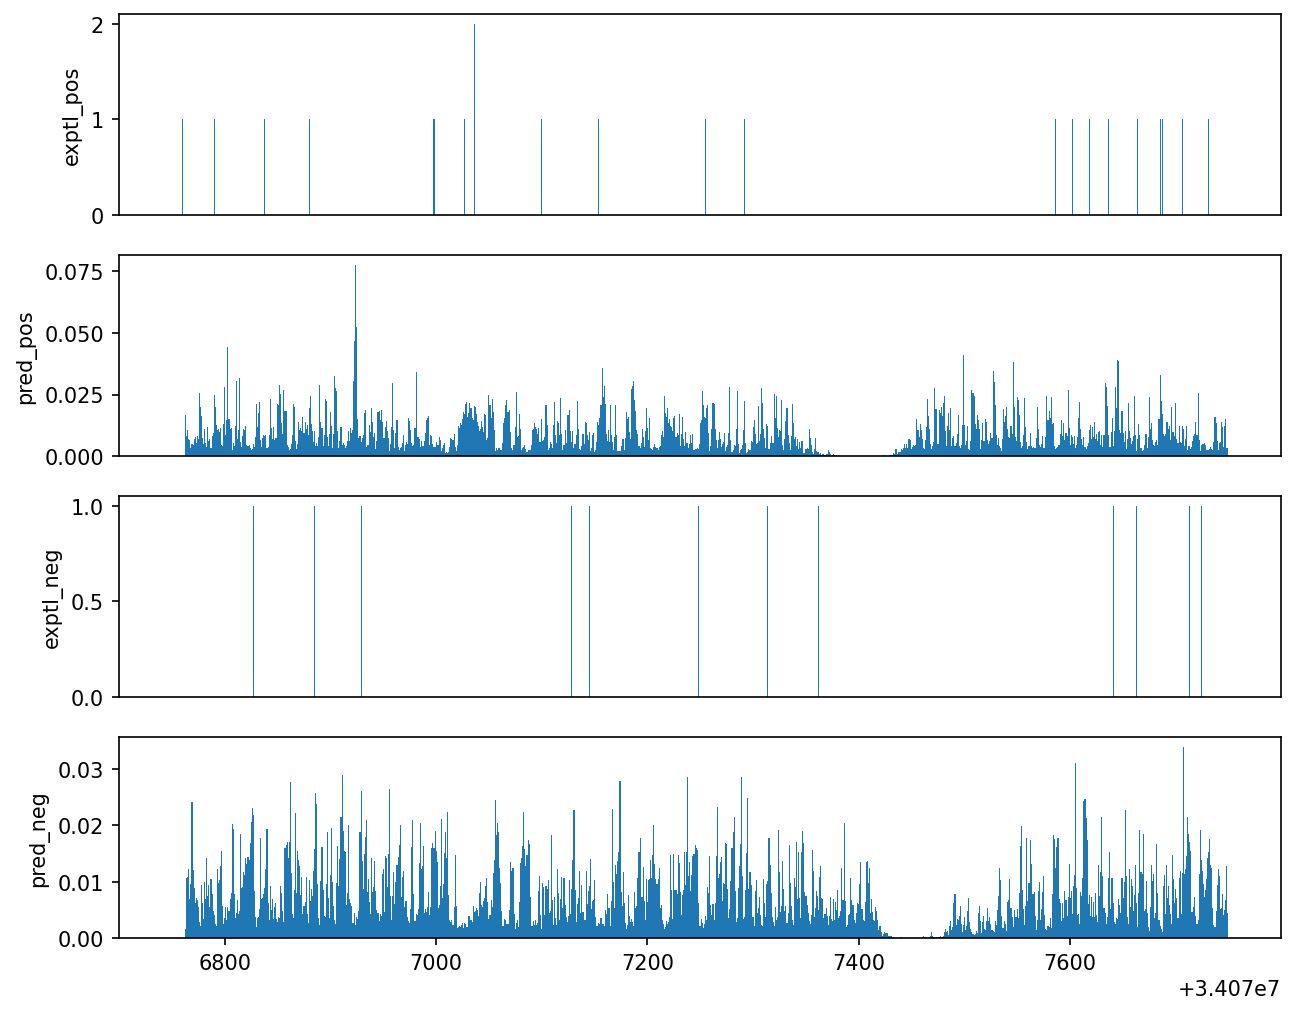

In [29]:
plotBws([DATA_DIRECTORY + "/data/chip-nexus/patchcap/counts.pos.bw",
         WORKING_DIRECTORY + "/pred/patchcap_positive.bw",
         DATA_DIRECTORY + "/data/chip-nexus/patchcap/counts.neg.bw", 
         WORKING_DIRECTORY + "/pred/patchcap_negative.bw"],
        ["exptl_pos", "pred_pos", "exptl_neg", "pred_neg"], "chr1", 34076750, 34077750)

In [30]:
#Huh. With so little patchcap data, it's really hard to tell if the model is doing a good job.
#In any event, it's time to train the transformation model up. 


# Training the transformation model

In [31]:
heads = []
for tfName in TF_NAMES:
    heads.append({"num-tasks" : 2, 
                  "profile-loss-weight" : 1, 
                  "head-name" : "patchcap_" + tfName,
                  "counts-loss-weight" : 100,
                  "counts-loss-frac-target" : 0.1})

transformationTrainConfig = {
    "settings" : {
        "output-prefix" : WORKING_DIRECTORY + "/models/transformation", 
        "epochs" : 200,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.04, #Note the very aggressive LR; we can do this because there are so few parameters. 
        "learning-rate-plateau-patience" : 5,
        "solo-model-file" : WORKING_DIRECTORY + "/models/solo.model",
        "input-length" : INPUT_LENGTH, 
        "output-length" : OUTPUT_LENGTH,
        "max-jitter" : 100,
        "profile-architecture" : {
            "name" : "simple", 
            "types" : ["linear", "sigmoid"]},
        "counts-architecture" : {
            "name" : "simple", 
            "types" : ["linear", "sigmoid"]}},
        
    "train-data" : WORKING_DIRECTORY+ "/input/peak_train.h5",
    "val-data" : WORKING_DIRECTORY + "/input/peak_val.h5",
    "heads" : heads,
    "verbosity" : "DEBUG"
}

print(json.dumps(transformationTrainConfig, indent=2))

with open(WORKING_DIRECTORY + "/json/trainTransformation.json", "w") as fp:
    json.dump(transformationTrainConfig, fp)

{
  "settings": {
    "output-prefix": "/n/projects/cm2363/bpreveal/test/oskn/models/transformation",
    "epochs": 200,
    "early-stopping-patience": 20,
    "batch-size": 128,
    "learning-rate": 0.04,
    "learning-rate-plateau-patience": 5,
    "solo-model-file": "/n/projects/cm2363/bpreveal/test/oskn/models/solo.model",
    "input-length": 3092,
    "output-length": 1000,
    "max-jitter": 100,
    "profile-architecture": {
      "name": "simple",
      "types": [
        "linear",
        "sigmoid"
      ]
    },
    "counts-architecture": {
      "name": "simple",
      "types": [
        "linear",
        "sigmoid"
      ]
    }
  },
  "train-data": "/n/projects/cm2363/bpreveal/test/oskn/input/peak_train.h5",
  "val-data": "/n/projects/cm2363/bpreveal/test/oskn/input/peak_val.h5",
  "heads": [
    {
      "num-tasks": 2,
      "profile-loss-weight": 1,
      "head-name": "patchcap_oct4",
      "counts-loss-weight": 100,
      "counts-loss-frac-target": 0.1
    },
    {
      

In [32]:
jobsGpu(SLURM_CONFIG, ["trainTransformationModel {0:s}".format(WORKING_DIRECTORY + "/json/trainTransformation.json")],
        "trainTransformation", 10, 60, "10:00:00")


In [33]:
#Let's go ahead and make predictions...
transformPredictConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-h5" : WORKING_DIRECTORY + "/pred/transform.h5", 
        "batch-size" : 128,
        "heads" : 4,
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/transformation.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "verbosity" : "DEBUG"
}

print(transformPredictConfig)

with open(WORKING_DIRECTORY + "/json/predictTransformation.json", "w") as fp:
    json.dump(transformPredictConfig, fp)


{'settings': {'genome': '/n/data1/genomes/indexes/mm10/mm10.fa', 'output-h5': '/n/projects/cm2363/bpreveal/test/oskn/pred/transform.h5', 'batch-size': 128, 'heads': 4, 'architecture': {'model-file': '/n/projects/cm2363/bpreveal/test/oskn/models/transformation.model', 'input-length': 3092, 'output-length': 1000}}, 'bed-file': '/n/projects/cm2363/bpreveal/test/oskn/bed/peak_all.bed', 'verbosity': 'DEBUG'}


In [34]:
jobsGpu(SLURM_CONFIG, ["makePredictionsBed {0:s}".format(WORKING_DIRECTORY + "/json/predictTransformation.json")],
        "predictTransformation", 1, 50, "10:00:00")

predCmd = "predictToBigwig " +\
          "--h5 {0:s}/pred/transform.h5 " +\
          "--bw {0:s}/pred/transform_{1:s}.bw "+\
          "--head-id 0 --task-id {2:d} --mode profile "+\
          "--threads 15 --verbose"

jobsNonGpu(SLURM_CONFIG, [predCmd.format(WORKING_DIRECTORY, strand[0], strand[1]) for strand in [("positive", 0), ("negative", 1)]], 
           "predToBigwigTransform", 15, 20, "1:00:00")


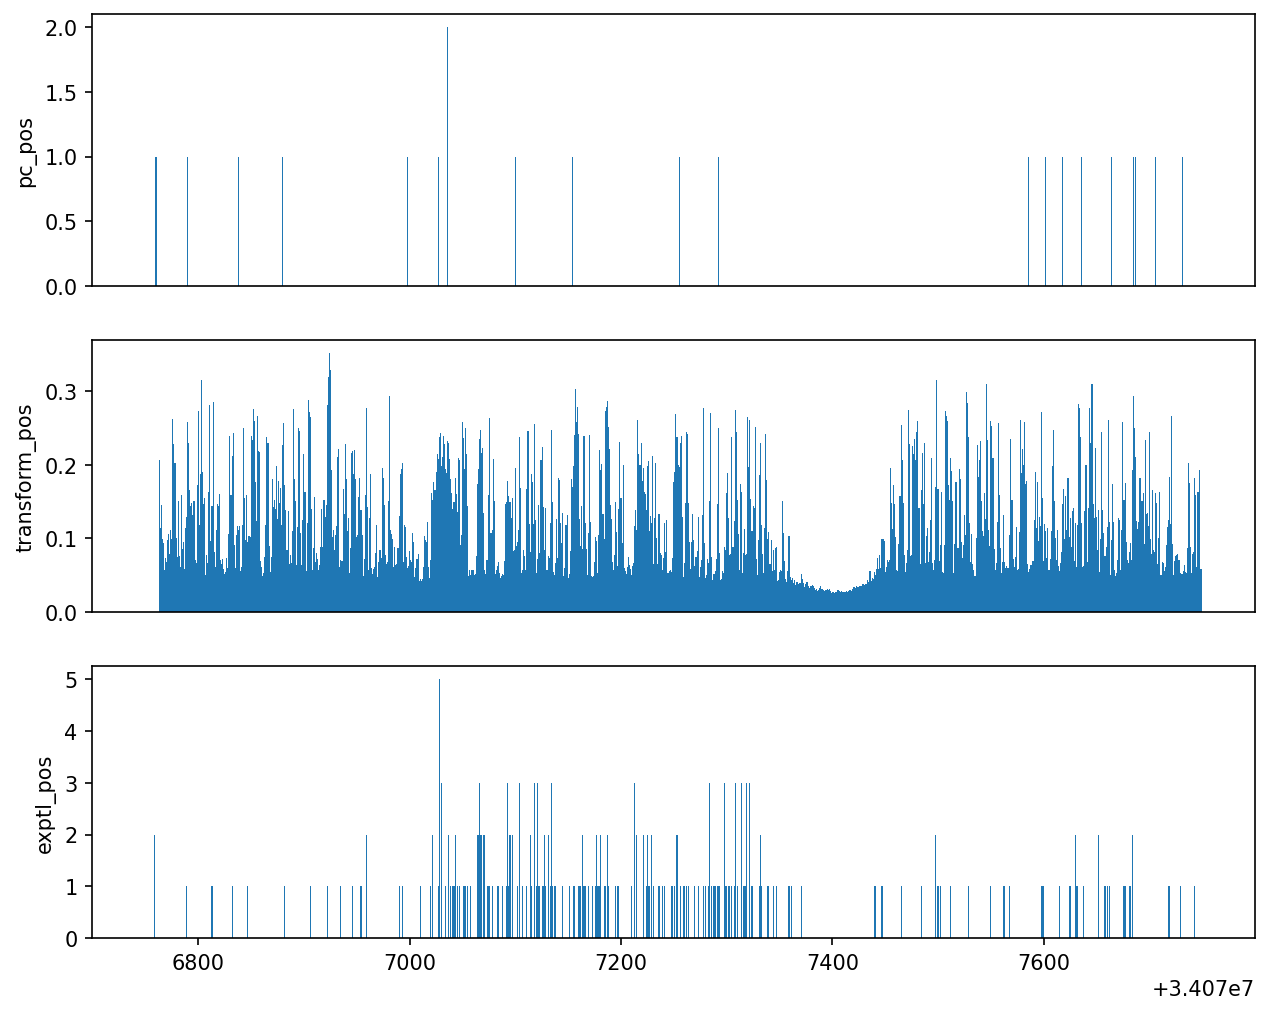

In [35]:
plotBws([DATA_DIRECTORY + "/data/chip-nexus/patchcap/counts.pos.bw",
         WORKING_DIRECTORY + "/pred/transform_positive.bw",
         DATA_DIRECTORY + "/data/chip-nexus/nanog/counts.pos.bw"],
        ["pc_pos", "transform_pos", "exptl_pos"], "chr1", 34076750, 34077750)

In [36]:
#Of course these aren't a good match, but that's partly the point - the bald spot that the patchcap model predicts seems to also be present in the Nanog and Oct4 experimental data,
#and this suggests that that bald spot is an artifact. 

# Training the combined model

In [37]:
heads = []
for tfName in TF_NAMES:
    heads.append({"num-tasks" : 2, 
                  "profile-loss-weight" : 1, 
                  "head-name" : "combined_" + tfName,
                  "counts-loss-weight" : 100,
                  "counts-loss-frac-target" : 0.1,
                  "use-bias-counts" : False})


#And now the whole config file:
combinedTrainConfig = {
    "settings" : {
        "output-prefix" : WORKING_DIRECTORY + "/models/joint", 
        "epochs" : 200,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.004,
        "learning-rate-plateau-patience" : 5,
        "max-jitter" : 100,
        "transformation-model" : {
            "transformation-model-file" : WORKING_DIRECTORY + "/models/transformation.model"
        },
        "architecture" : {
            "architecture-name" : "bpnet", 
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH,
            "model-name" : "joint",
            "model-args" : "",
            "filters" : 64,
            "layers" : 9,
            "input-filter-width" : 25,
            "output-filter-width" : 25
        }
    },
    "train-data" : WORKING_DIRECTORY + "/input/peak_train.h5",
    "val-data" : WORKING_DIRECTORY + "/input/peak_val.h5",
    "heads" : heads,
    "verbosity" : "DEBUG"
}

print(json.dumps(combinedTrainConfig, indent=2))

with open(WORKING_DIRECTORY + "/json/trainCombined.json", "w") as fp:
    json.dump(combinedTrainConfig, fp)

{
  "settings": {
    "output-prefix": "/n/projects/cm2363/bpreveal/test/oskn/models/joint",
    "epochs": 200,
    "early-stopping-patience": 20,
    "batch-size": 128,
    "learning-rate": 0.004,
    "learning-rate-plateau-patience": 5,
    "max-jitter": 100,
    "transformation-model": {
      "transformation-model-file": "/n/projects/cm2363/bpreveal/test/oskn/models/transformation.model"
    },
    "architecture": {
      "architecture-name": "bpnet",
      "input-length": 3092,
      "output-length": 1000,
      "model-name": "joint",
      "model-args": "",
      "filters": 64,
      "layers": 9,
      "input-filter-width": 25,
      "output-filter-width": 25
    }
  },
  "train-data": "/n/projects/cm2363/bpreveal/test/oskn/input/peak_train.h5",
  "val-data": "/n/projects/cm2363/bpreveal/test/oskn/input/peak_val.h5",
  "heads": [
    {
      "num-tasks": 2,
      "profile-loss-weight": 1,
      "head-name": "combined_oct4",
      "counts-loss-weight": 100,
      "counts-loss-frac

In [38]:
jobsGpu(SLURM_CONFIG, ["trainCombinedModel {0:s}".format(WORKING_DIRECTORY + "/json/trainCombined.json")],
        "trainCombined", 10, 60, "10:00:00")


In [39]:
#Let's look at the losses...
!makeLossPlots --json {WORKING_DIRECTORY}/models/joint.history.json --output {WORKING_DIRECTORY}/models/joint.png

In [40]:
#It's overfitting a bit, maybe next time I'll try with fewer filters. 
#But now's the time to make predictions. 

In [41]:
combinedPredictConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-h5" : WORKING_DIRECTORY + "/pred/combined.h5", 
        "batch-size" : 128,
        "heads" : 4,
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/joint_combined.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "verbosity" : "DEBUG"
}

print(combinedPredictConfig)

with open(WORKING_DIRECTORY + "/json/predictCombined.json", "w") as fp:
    json.dump(combinedPredictConfig, fp)
#For the residual model, I just need to change a few terms:
residualPredictConfig = combinedPredictConfig
residualPredictConfig["settings"]["output-h5"] = WORKING_DIRECTORY + "/pred/residual.h5"
residualPredictConfig["settings"]["architecture"]["model-file"] = WORKING_DIRECTORY + "/models/joint_residual.model"
with open(WORKING_DIRECTORY + "/json/predictResidual.json", "w") as fp:
    json.dump(residualPredictConfig, fp)

{'settings': {'genome': '/n/data1/genomes/indexes/mm10/mm10.fa', 'output-h5': '/n/projects/cm2363/bpreveal/test/oskn/pred/combined.h5', 'batch-size': 128, 'heads': 4, 'architecture': {'model-file': '/n/projects/cm2363/bpreveal/test/oskn/models/joint_combined.model', 'input-length': 3092, 'output-length': 1000}}, 'bed-file': '/n/projects/cm2363/bpreveal/test/oskn/bed/peak_all.bed', 'verbosity': 'DEBUG'}


In [42]:
jobsGpu(SLURM_CONFIG, ["makePredictionsBed {0:s}".format(WORKING_DIRECTORY + "/json/predictCombined.json"),
         "makePredictionsBed {0:s}".format(WORKING_DIRECTORY + "/json/predictResidual.json")],
        "predictCombined", 1, 50, "10:00:00")


bwCmdBase = "predictToBigwig " +\
          "--h5 {wd:s}/pred/{inf:s}.h5 " +\
          "--bw {wd:s}/pred/{outf:s}.bw "+\
          "--head-id {hid:d} --task-id {tid:d} --mode profile "+\
          "--threads 15 --verbose"
bwCmds = []
for modelType in ["residual", "combined"]:
    for headid, tfname in enumerate(TF_NAMES):
        for tid, strand in enumerate(["positive", "negative"]):
            cmd = bwCmdBase.format(wd=WORKING_DIRECTORY, 
                                   inf=modelType,
                                   outf=tfname + "_" + modelType + "_" + strand,
                                   hid=headid, tid=tid)
            bwCmds.append(cmd)

jobsNonGpu(SLURM_CONFIG, bwCmds, 
           "predToBigwigCombined", 15, 20, "1:00:00")



In [43]:
def plotTfBigwigs(tfName, exptName, startPos = 34066036, span=1000, chrom="chr1"):
    plotBws([DATA_DIRECTORY + "/data/chip-nexus/" + tfName + "/counts.pos.bw",
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_positive.bw",
             DATA_DIRECTORY + "/data/chip-nexus/" + tfName + "/counts.neg.bw", 
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_negative.bw"],
            ["exptl_pos", "pred_pos", "exptl_neg", "pred_neg"], chrom, startPos, startPos+span)

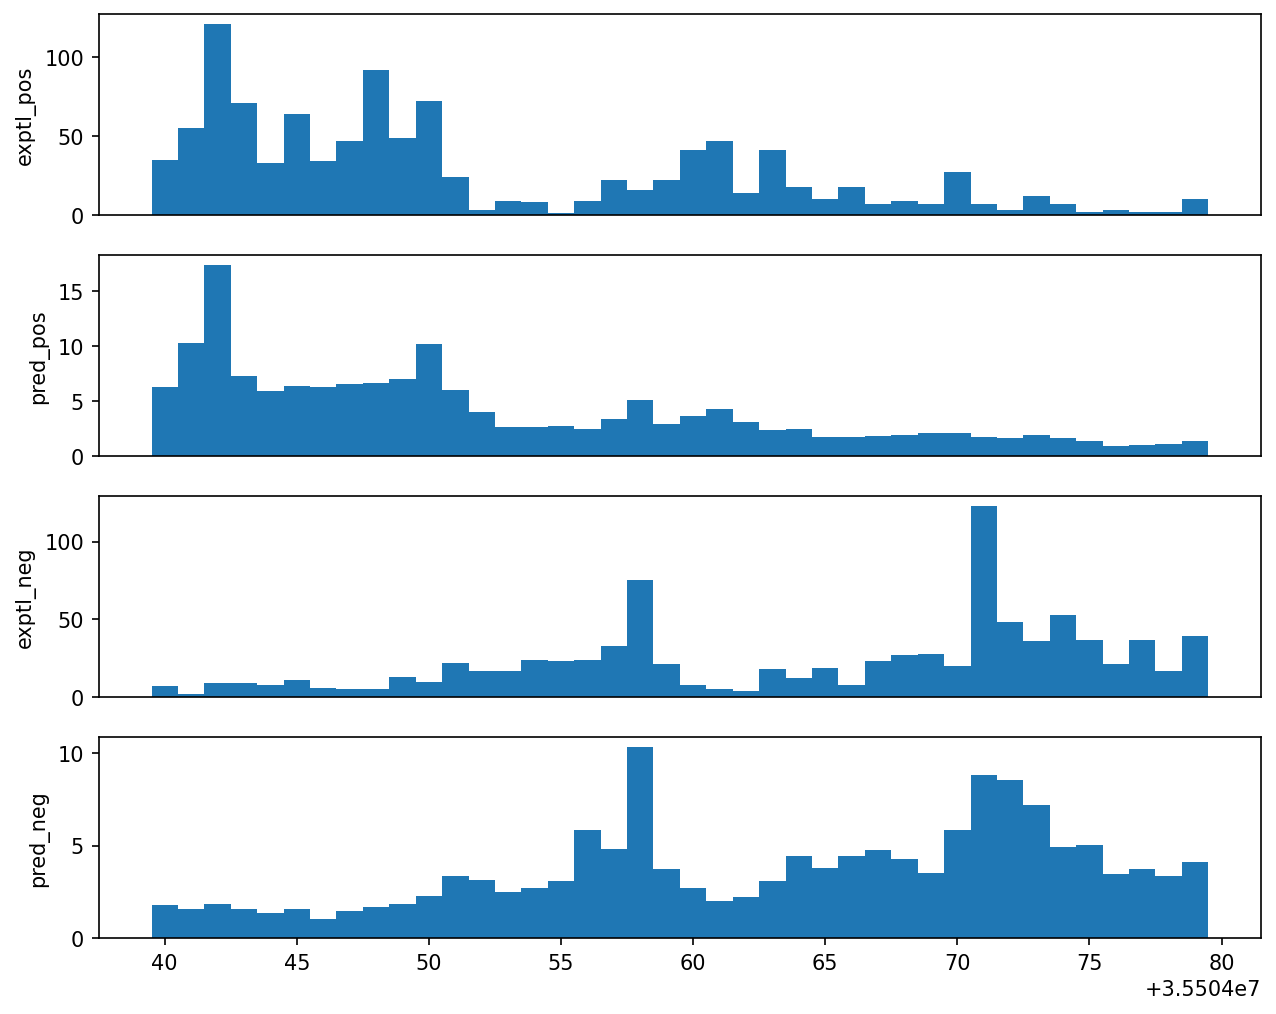

In [44]:
plotTfBigwigs('oct4', 'residual', startPos = 35504040, span=40, chrom="chr17")

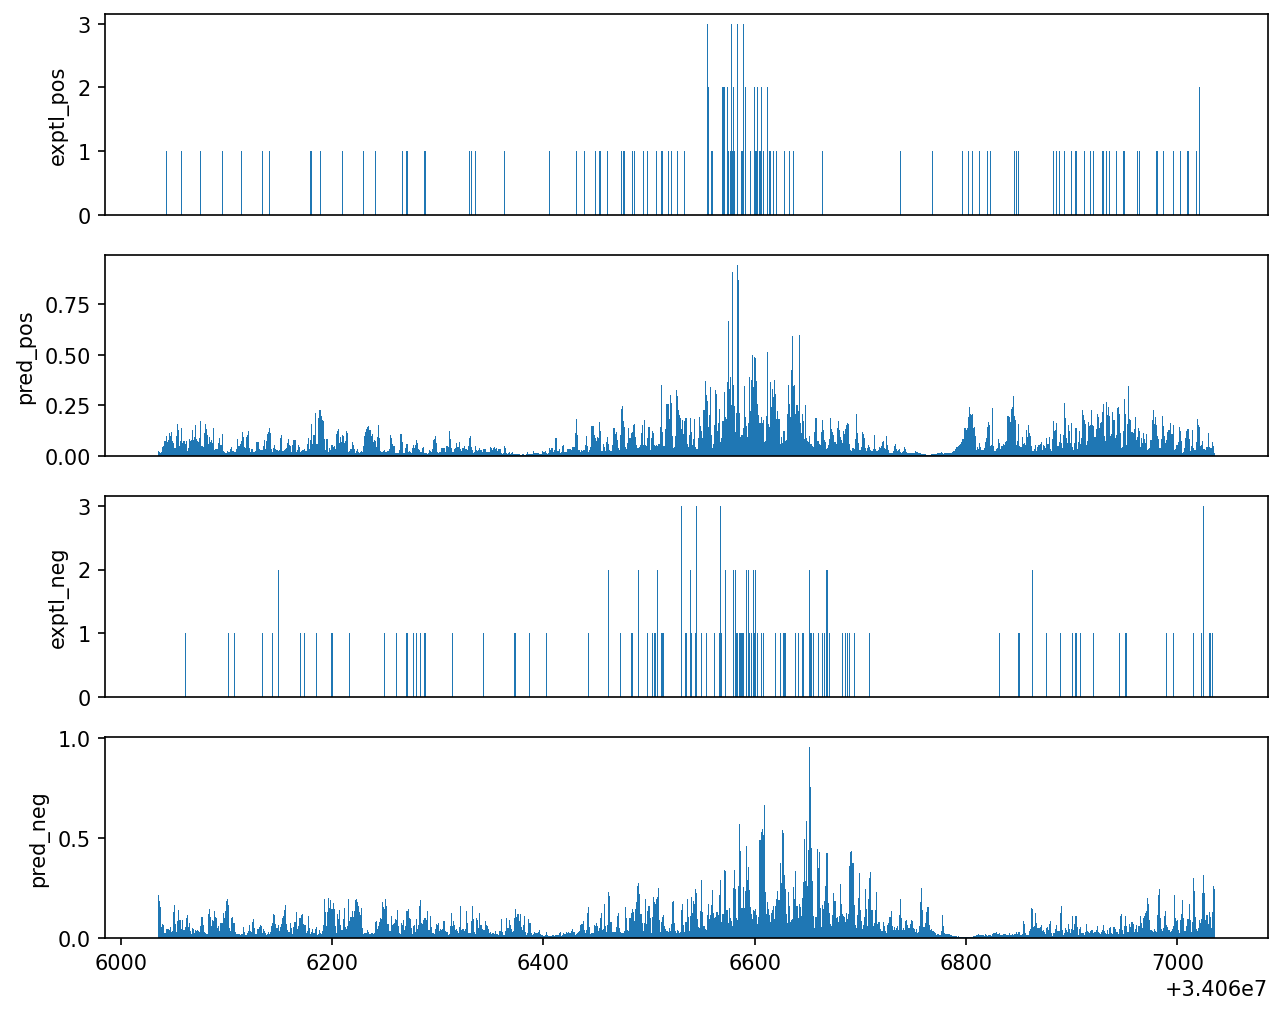

In [45]:
plotTfBigwigs('oct4', 'combined')

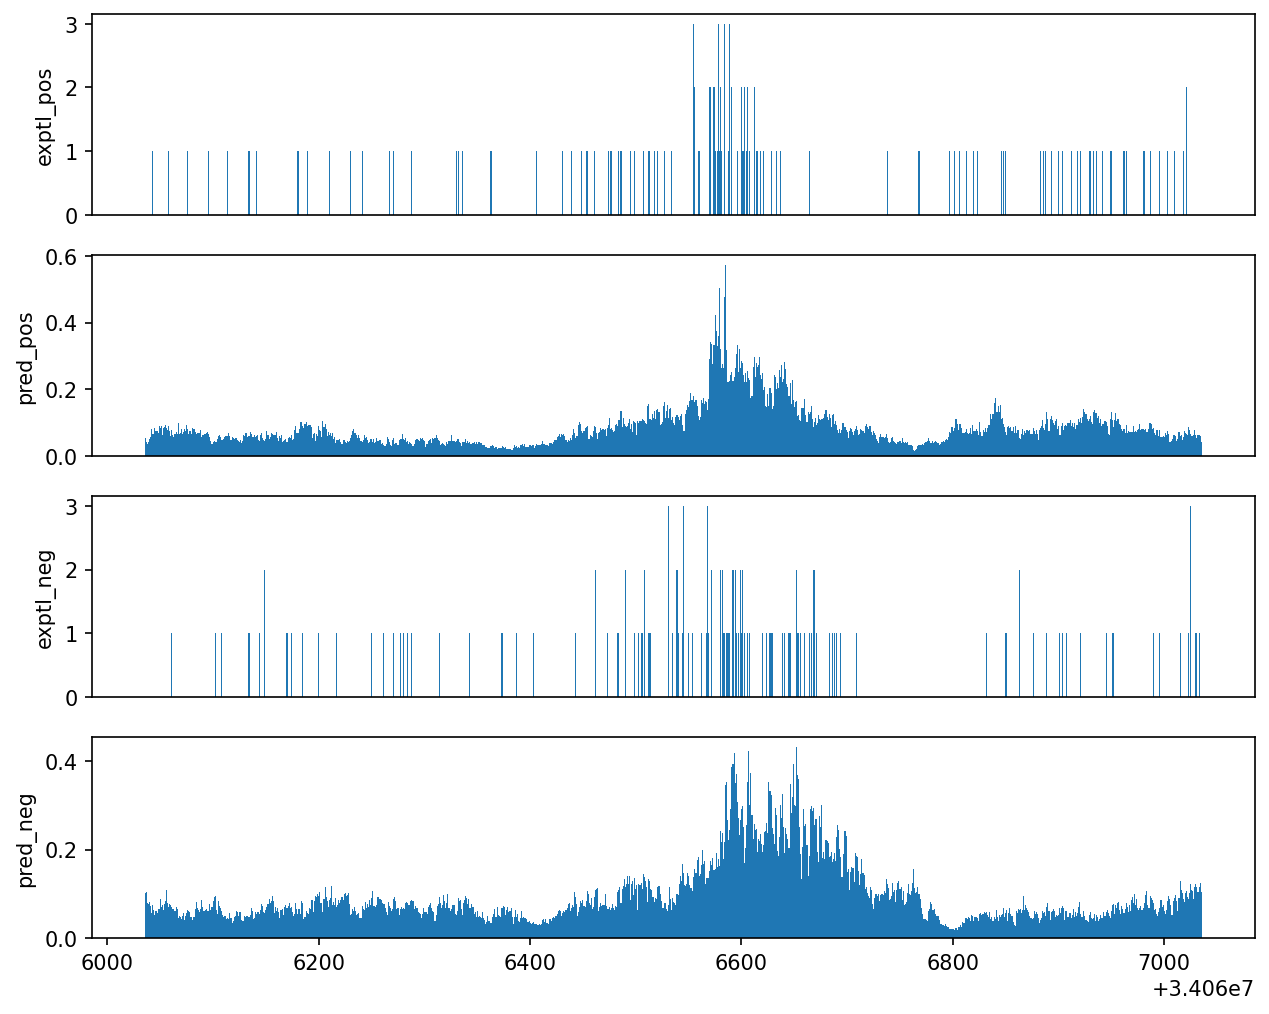

In [46]:
plotTfBigwigs('oct4', 'residual')

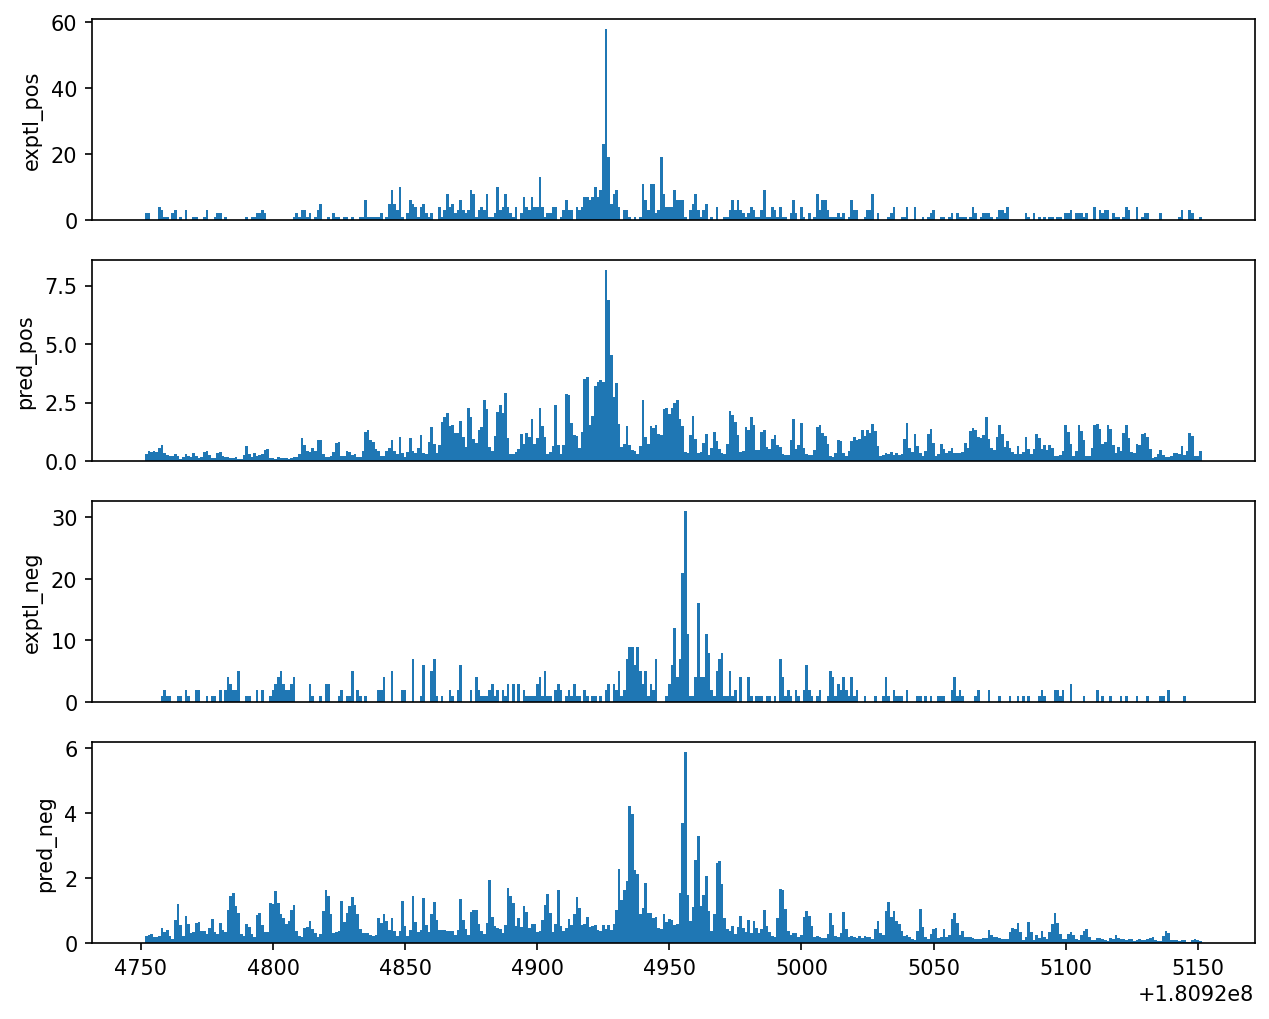

In [47]:
#Let's look around our favorite Lefty1 enhancer...
plotTfBigwigs('oct4', 'combined', startPos = 180924752, span=400)

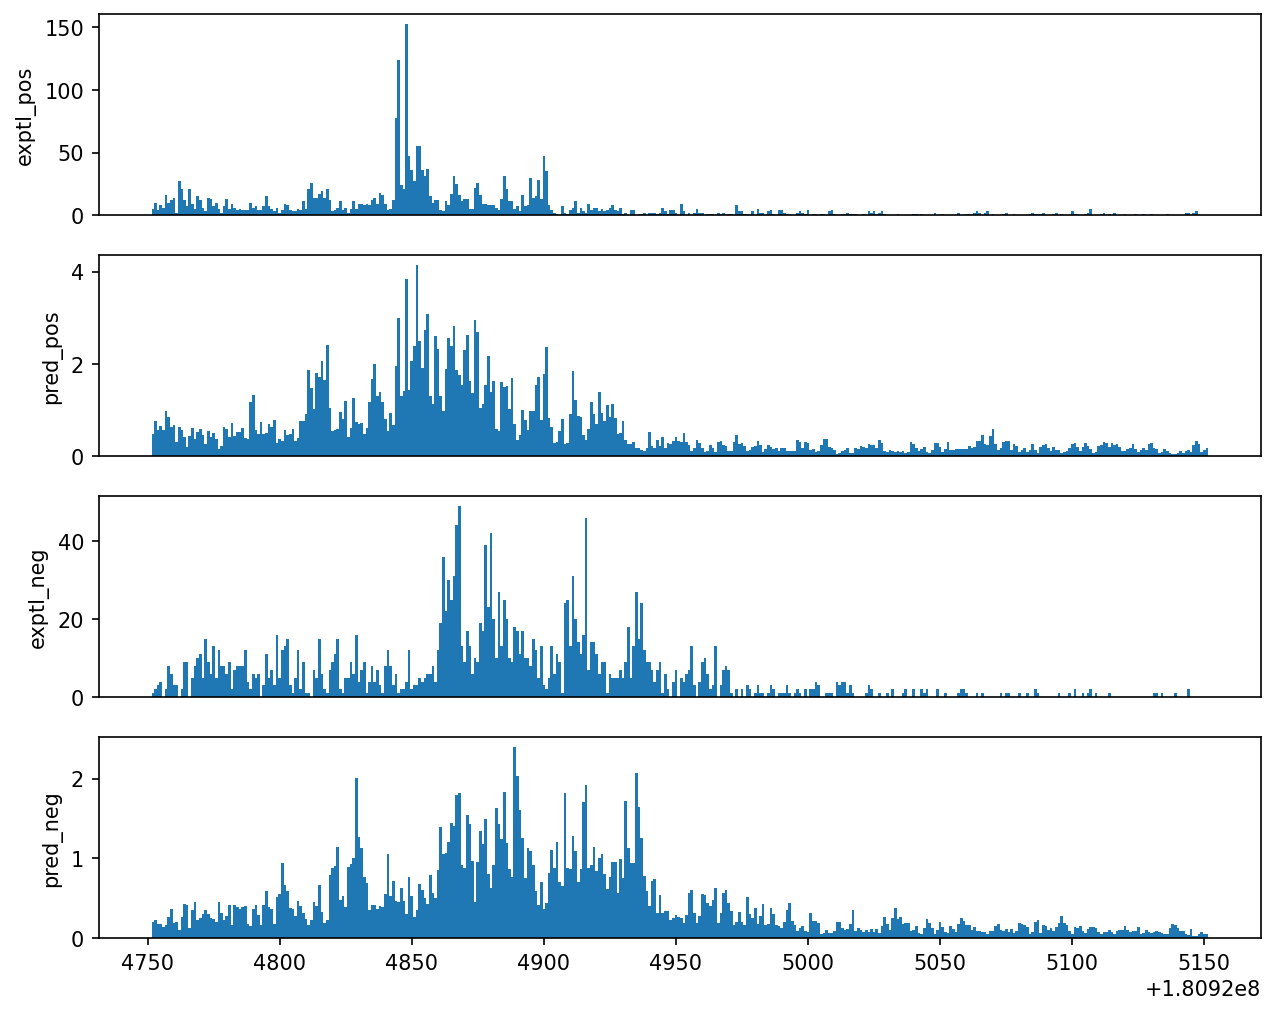

In [48]:
plotTfBigwigs('nanog', 'combined', startPos = 180924752, span=400)

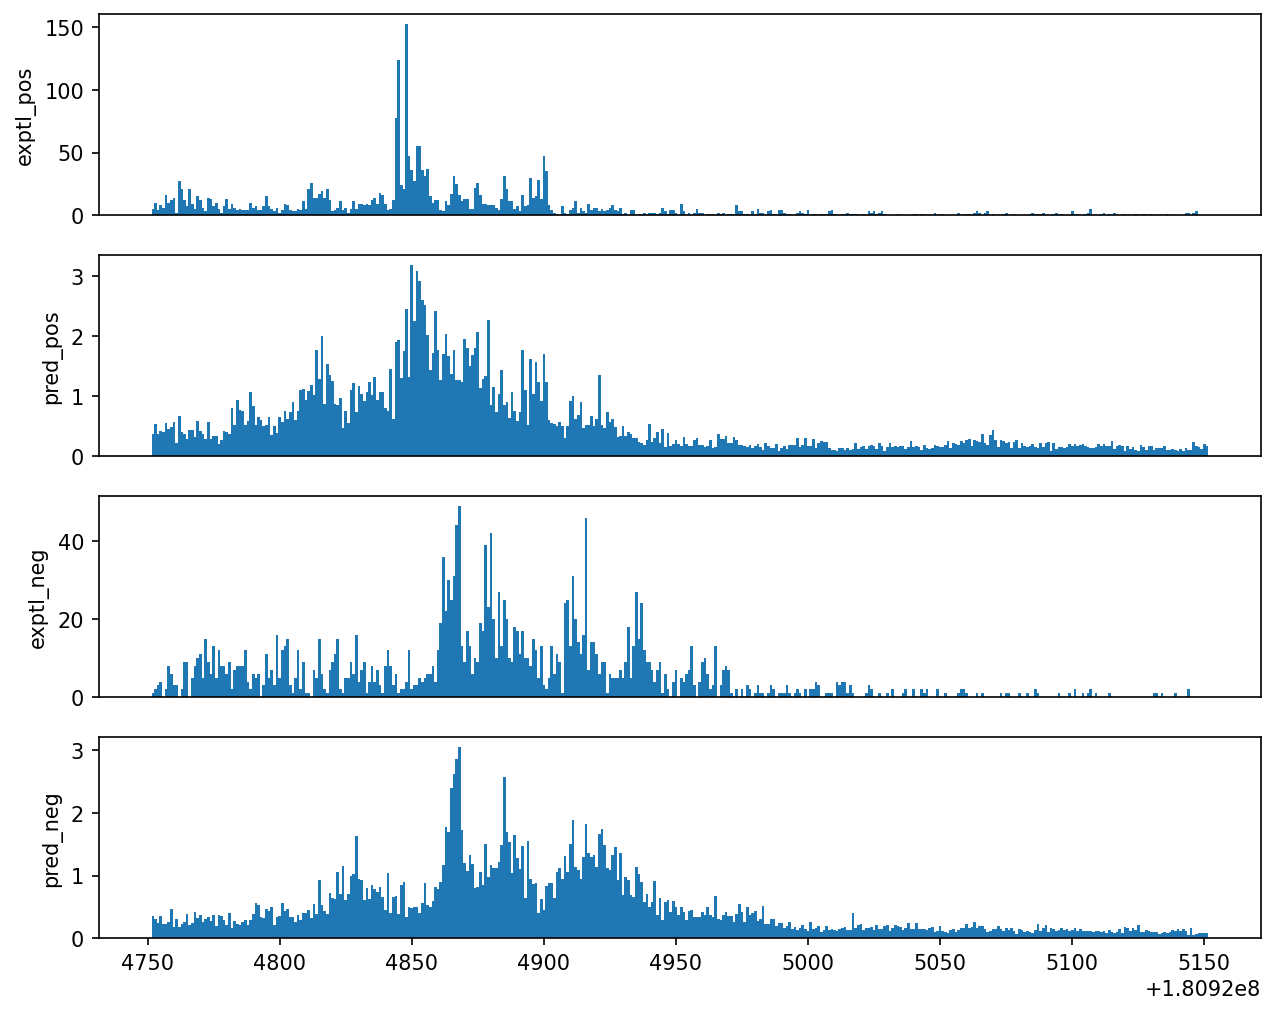

In [49]:
plotTfBigwigs('nanog', 'residual', startPos = 180924752, span=400)

In [50]:
!metrics --reference {DATA_DIRECTORY}/data/chip-nexus/oct4/counts.pos.bw \
         --pred {WORKING_DIRECTORY}/pred/oct4_combined_positive.bw \
         --regions {WORKING_DIRECTORY}/bed/peak_train.bed \
         --threads 20 --apply-abs --skip-zeroes

!metrics --reference {DATA_DIRECTORY}/data/chip-nexus/oct4/counts.pos.bw \
         --pred {WORKING_DIRECTORY}/pred/oct4_combined_positive.bw \
         --regions {WORKING_DIRECTORY}/bed/peak_val.bed \
         --threads 20 --apply-abs --skip-zeroes

reference /n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/oct4/counts.pos.bw predicted /n/projects/cm2363/bpreveal/test/oskn/pred/oct4_combined_positive.bw regions /n/projects/cm2363/bpreveal/test/oskn/bed/peak_train.bed
100%|██████████████████████████████████| 71373/71373 [00:06<00:00, 11778.53it/s]
metric    	      0.000000%	     25.000000%	     50.000000%	     75.000000%	    100.000000%	regions
mnll      	   -4301.307704	    -424.333464	    -331.816350	    -262.058460	      -5.922858	71371
jsd       	       0.258494	       0.661440	       0.698364	       0.726038	       0.830394	71371
pearsonr  	      -0.100414	       0.159743	       0.205038	       0.271518	       0.928760	71371
spearmanr 	      -0.167446	       0.157777	       0.195151	       0.246138	       0.808915	71371
Counts pearson 	  0.579160
Counts spearman	  0.632050
reference /n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/oct4/counts.pos.bw predicted /n/projects/cm2363/bprevea

In [51]:
!metrics --reference {DATA_DIRECTORY}/data/chip-nexus/oct4/counts.pos.bw \
         --pred {DATA_DIRECTORY}/bigwigs/Oct4.preds.pos.bw \
         --regions {WORKING_DIRECTORY}/bed/peak_train.bed \
         --threads 20 --apply-abs --skip-zeroes
!metrics --reference {DATA_DIRECTORY}/data/chip-nexus/oct4/counts.pos.bw \
         --pred {DATA_DIRECTORY}/bigwigs/Oct4.preds.pos.bw \
         --regions {WORKING_DIRECTORY}/bed/peak_val.bed \
         --threads 20 --apply-abs --skip-zeroes

reference /n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/oct4/counts.pos.bw predicted /n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/bigwigs/Oct4.preds.pos.bw regions /n/projects/cm2363/bpreveal/test/oskn/bed/peak_train.bed
100%|██████████████████████████████████| 71373/71373 [00:04<00:00, 14892.68it/s]
metric    	      0.000000%	     25.000000%	     50.000000%	     75.000000%	    100.000000%	regions
mnll      	   -4020.882326	    -472.177614	    -371.320868	    -298.906461	     -44.751772	32963
jsd       	       0.232071	       0.637508	       0.679624	       0.710673	       0.832555	51844
pearsonr  	      -0.145036	       0.176555	       0.233182	       0.320073	       0.932085	51844
spearmanr 	      -0.254353	       0.167652	       0.213595	       0.276396	       0.814223	51844
Counts pearson 	  0.442250
Counts spearman	  0.470066
reference /n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/data/chip-nexus/oct4/counts.pos.bw predicted /n/projects/cm2

In [52]:
!metrics --reference {WORKING_DIRECTORY}/pred/oct4_combined_positive.bw \
         --pred {DATA_DIRECTORY}/bigwigs/Oct4.preds.pos.bw \
         --regions {WORKING_DIRECTORY}/bed/peak_train.bed \
         --threads 20 --apply-abs --skip-zeroes
!metrics --reference {WORKING_DIRECTORY}/pred/oct4_combined_positive.bw \
         --pred {DATA_DIRECTORY}/bigwigs/Oct4.preds.pos.bw \
         --regions {WORKING_DIRECTORY}/bed/peak_val.bed \
         --threads 20 --apply-abs --skip-zeroes

reference /n/projects/cm2363/bpreveal/test/oskn/pred/oct4_combined_positive.bw predicted /n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/bigwigs/Oct4.preds.pos.bw regions /n/projects/cm2363/bpreveal/test/oskn/bed/peak_train.bed
100%|██████████████████████████████████| 71373/71373 [00:04<00:00, 14803.51it/s]
metric    	      0.000000%	     25.000000%	     50.000000%	     75.000000%	    100.000000%	regions
mnll      	       0.000000	       0.000000	       0.000000	       0.000000	       0.000000	5
jsd       	       0.071845	       0.127337	       0.151747	       0.188081	       0.831283	51844
pearsonr  	      -0.398881	       0.750687	       0.837679	       0.891640	       0.981142	51844
spearmanr 	      -0.700212	       0.793553	       0.866962	       0.909480	       0.983769	51844
Counts pearson 	  0.569996
Counts spearman	  0.542310
reference /n/projects/cm2363/bpreveal/test/oskn/pred/oct4_combined_positive.bw predicted /n/projects/cm2363/bpreveal/test/oskn/bpnet-pub-local/bigwi

# Deriving flat importance scores

In [53]:
#Importance scores are needed to run motif discovery, but they're also a great way to analyze what the model learned. 
#Unfortunately for us, they take a while to generate. 
def makeInterpretJson(tfNum):
    return {
        "genome" : GENOME_FASTA,
        "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
        "model-file" : WORKING_DIRECTORY + "/models/joint_residual.model", 
        "input-length" : INPUT_LENGTH,
        "output-length" : OUTPUT_LENGTH,
        "heads" : 4,
        "head-id": tfNum,
        "profile-task-ids" : [0,1],
        "profile-h5" : WORKING_DIRECTORY + "/shap/" + TF_NAMES[tfNum] + "_profile.h5",
        "counts-h5" : WORKING_DIRECTORY + "/shap/" + TF_NAMES[tfNum] + "_counts.h5",
        "num-shuffles" : 20,
        "verbosity" : "DEBUG"}
cmds = []
for tfNum in range(len(TF_NAMES)):
    fname = WORKING_DIRECTORY + "/json/shap_" + TF_NAMES[tfNum] + ".json"
    cmds.append("interpretFlat {0:s}".format(fname))
    with open(fname, "w") as fp:
        json.dump(makeInterpretJson(tfNum), fp)
jobsGpu(SLURM_CONFIG, cmds,
        "interpretFlat", 5, 50, "10:00:00")

In [54]:
shapBwCmdBase = "shapToBigwig " +\
          "--h5 {wd:s}/shap/{tf:s}_{readout:s}.h5 " +\
          "--bw {wd:s}/shap/{tf:s}_{readout:s}.bw "+\
          "--verbose"
shapBwCmds = []
for tfname in TF_NAMES:
    for readout in ["profile", "counts"]:
        cmd = shapBwCmdBase.format(wd=WORKING_DIRECTORY, 
                                   tf=tfname,
                                   readout=readout)
        shapBwCmds.append(cmd)

jobsNonGpu(SLURM_CONFIG, shapBwCmds, 
           "shapToBigwig", 2, 20, "1:00:00")



In [55]:
def plotShapBigwigs(tfName, exptName, startPos = 34066036, span=1000, chrom="chr1"):
    plotBws([WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_positive.bw",
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_negative.bw",
             WORKING_DIRECTORY + "/shap/" + tfName + "_profile.bw", 
             WORKING_DIRECTORY + "/shap/" + tfName + "_counts.bw"],
            ["pred_pos", "pred_neg", "profile", "counts"], chrom, startPos, startPos+span)

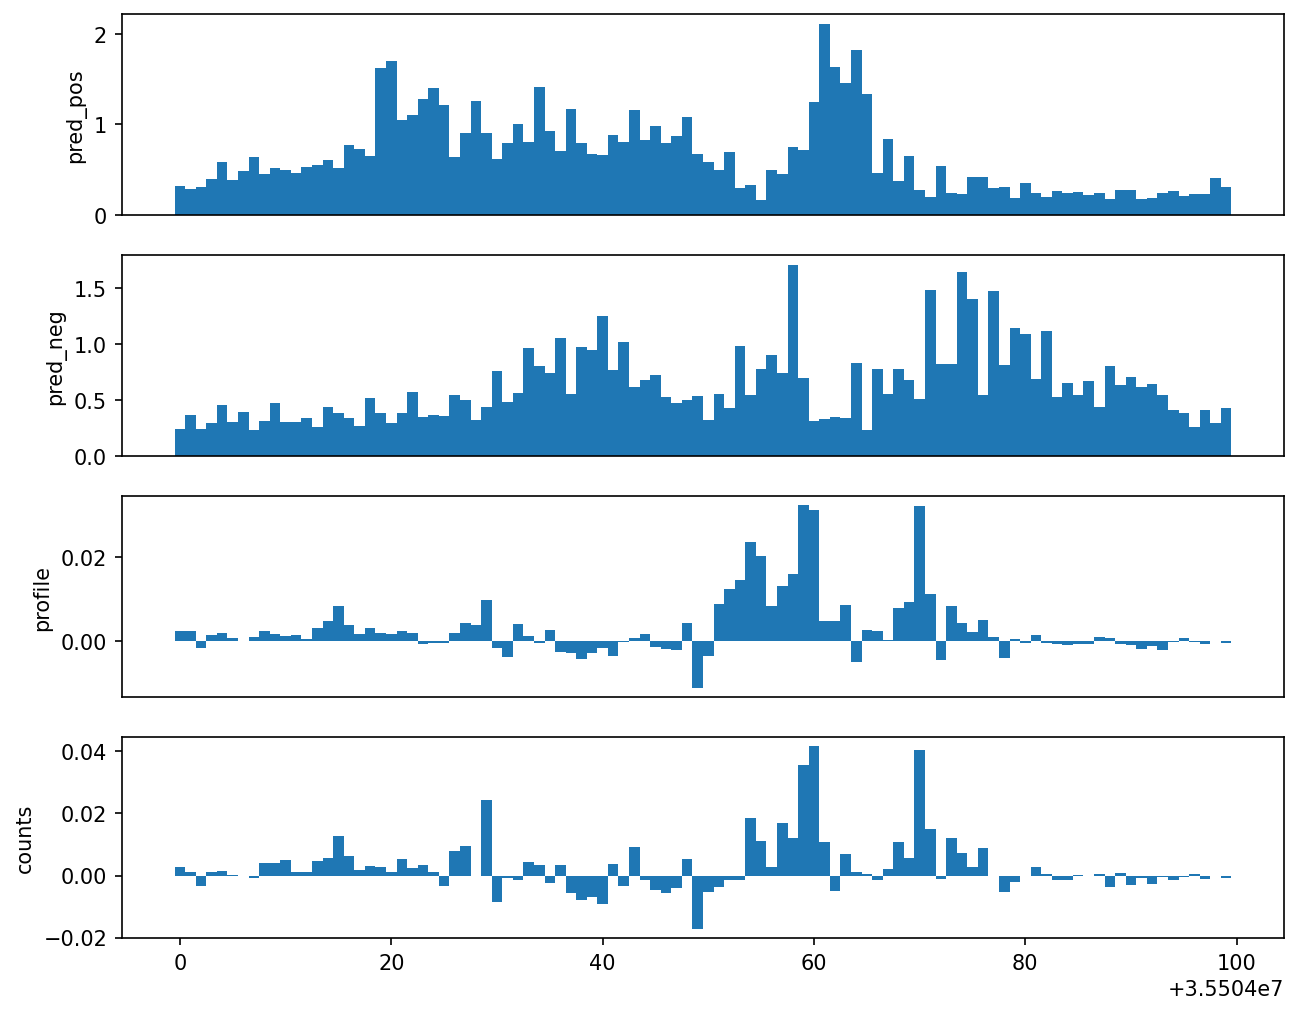

In [56]:
plotShapBigwigs("nanog", "residual", startPos = 35504000, span=100, chrom="chr17")

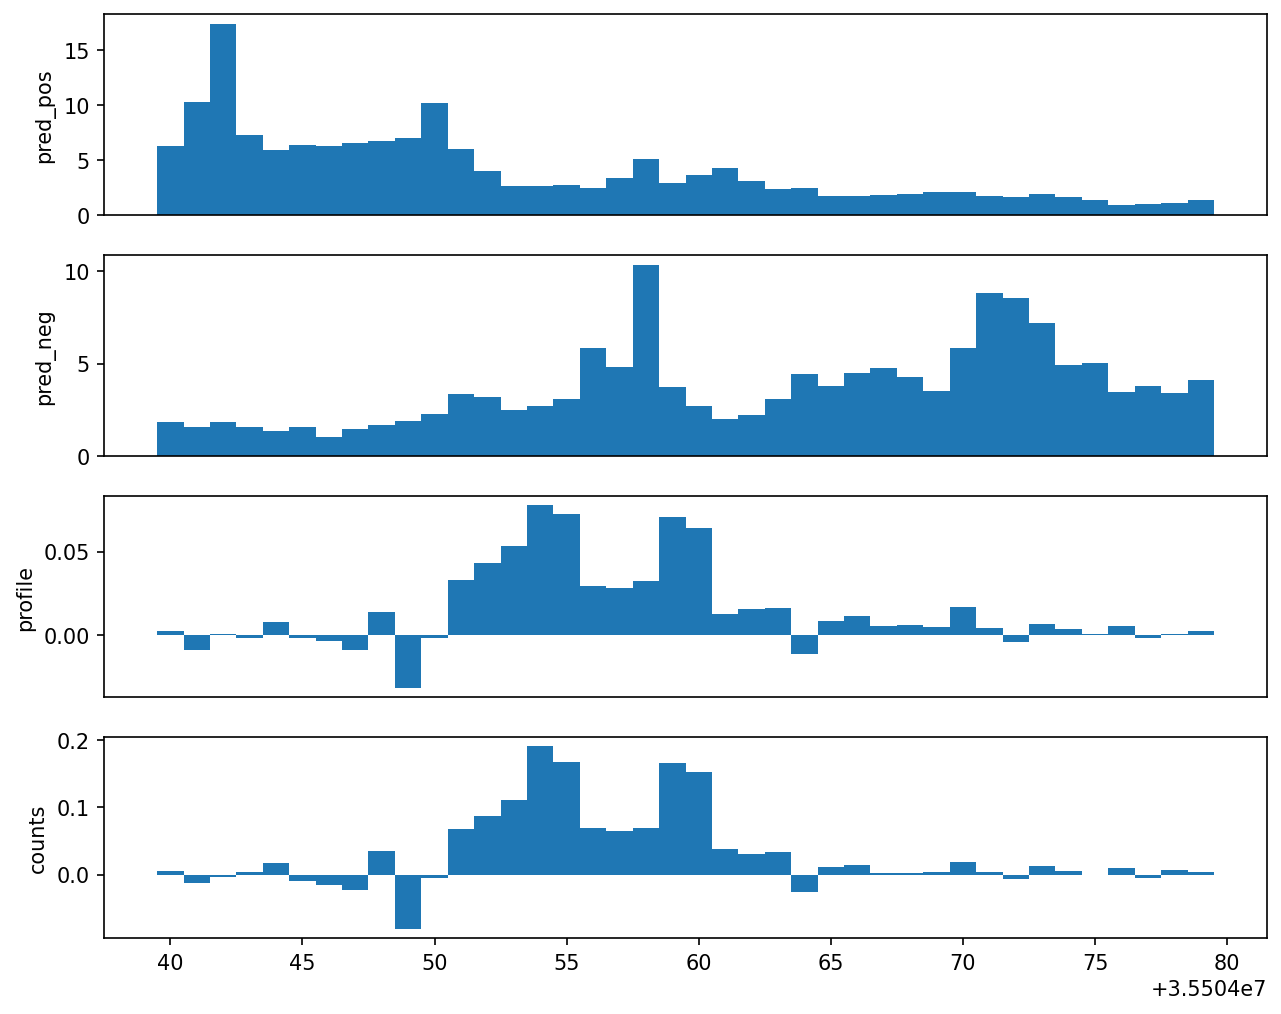

In [57]:
plotShapBigwigs('oct4', 'residual', startPos = 35504040, span=40, chrom="chr17")

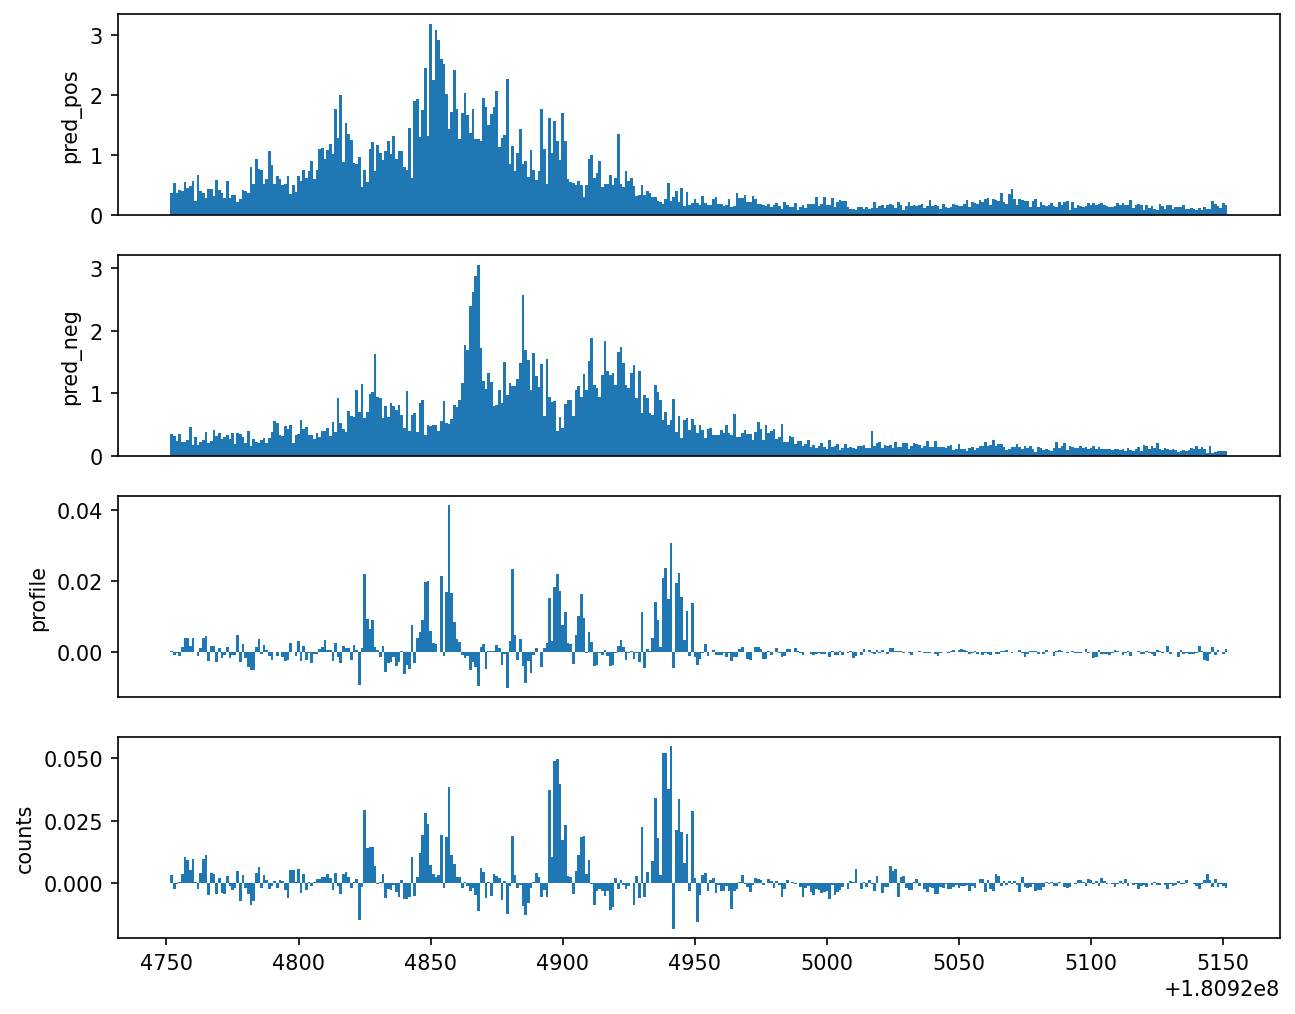

In [58]:
plotShapBigwigs('nanog', 'residual', startPos = 180924752, span=400)

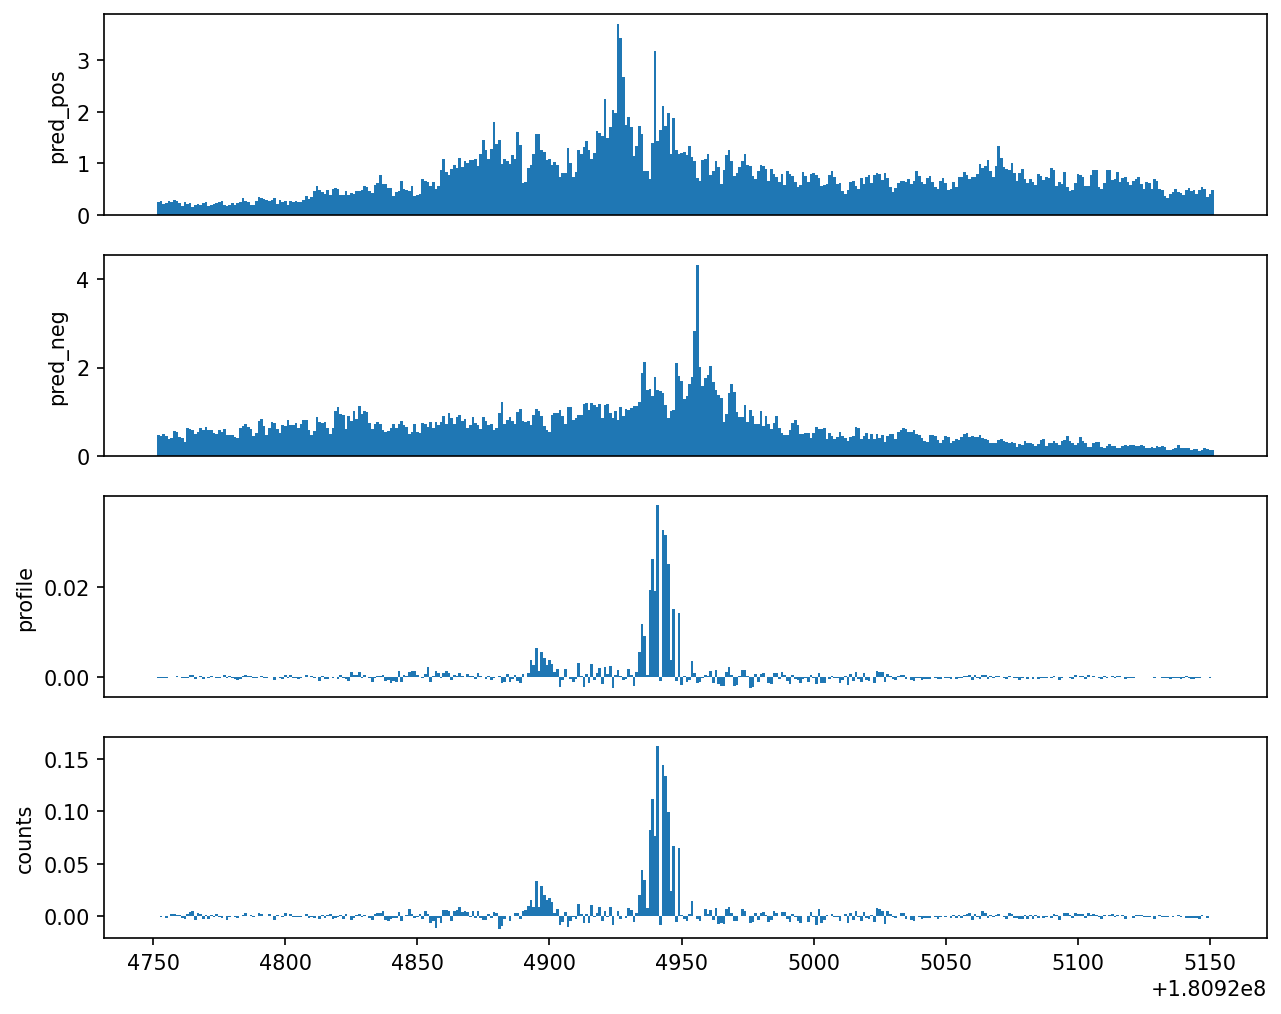

In [59]:
plotShapBigwigs('oct4', 'residual', startPos = 180924752, span=400)

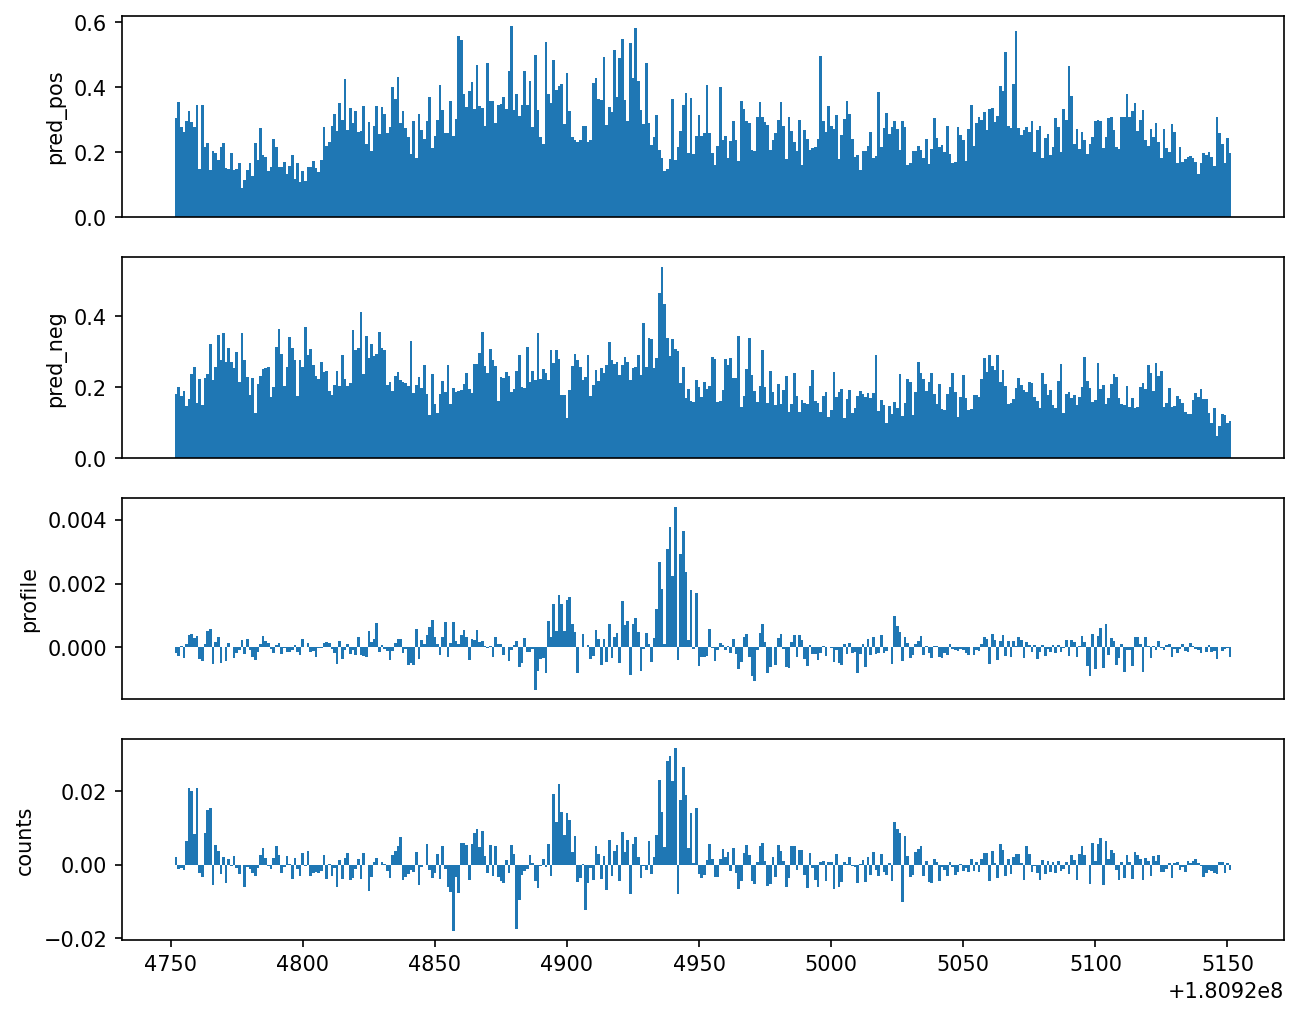

In [60]:
plotShapBigwigs('klf4', 'residual', startPos = 180924752, span=400)

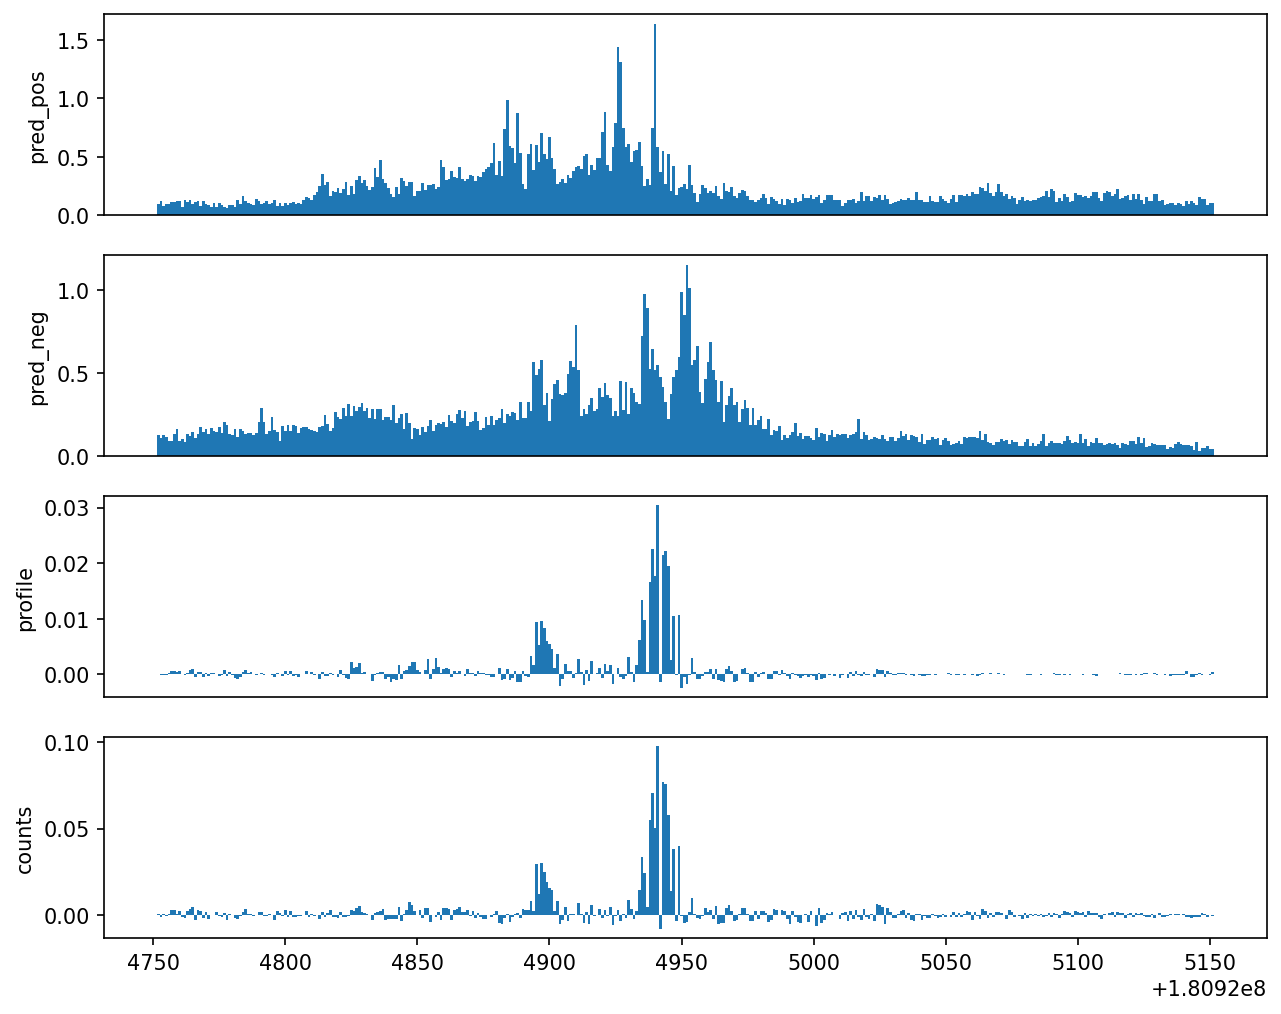

In [61]:
plotShapBigwigs('sox2', 'residual', startPos = 180924752, span=400)

In [62]:
#Great, so we have those bigwigs and the importance hdf5. I can run Modisco now! 
#The first thing to do is to export the shap scores as numpy arrays, then I run Modisco proper, 
#and finally I generate reports. 

shapToNumpyCmdBase = "shapToNumpy " +\
          "--h5 {wd:s}/shap/{tf:s}_{readout:s}.h5 " +\
          "--seqs {wd:s}/shap/seqs_{tf:s}_{readout:s}.npz "+\
          "--scores {wd:s}/shap/scores_{tf:s}_{readout:s}.npz "+\
          "--verbose"
shapToNumpyCmds = []
for tfname in TF_NAMES:
    for readout in ["profile", "counts"]:
        cmd = shapToNumpyCmdBase.format(wd=WORKING_DIRECTORY, 
                                        tf=tfname,
                                        readout=readout)
        shapToNumpyCmds.append(cmd)

jobsNonGpu(SLURM_CONFIG, shapToNumpyCmds, 
           "shapToNumpy", 2, 20, "1:00:00")

In [63]:
modiscoCmdBase = "mkdir -p {wd:s}/modisco/{tf:s}_{readout:s}\n" +\
          "modisco motifs " +\
              "-s {wd:s}/shap/seqs_{tf:s}_{readout:s}.npz " +\
              "-a {wd:s}/shap/scores_{tf:s}_{readout:s}.npz "+\
              "-n 100000 " +\
              "-w 1000 "+\
              "-v " +\
              "-o {wd:s}/modisco/{tf:s}_{readout:s}/modisco.h5 "
modiscoCmds = []
for tfname in TF_NAMES:
    for readout in ["profile", "counts"]:
        cmd = modiscoCmdBase.format(wd=WORKING_DIRECTORY, 
                                        tf=tfname,
                                        readout=readout)
        modiscoCmds.append(cmd)

jobsNonGpu(SLURM_CONFIG, modiscoCmds, 
           "modisco", 70, 600, "50:00:00")

In [64]:
reportCmdBase = "modisco report " +\
              "-i {wd:s}/modisco/{tf:s}_{readout:s}/modisco.h5 " +\
              "-o {wd:s}/modisco/{tf:s}_{readout:s}/ "+\
              "-n 2 " +\
              "-m /n/data1/JASPAR/2022/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme.txt " +\
              "\n\n{sd:s}/annotateModiscoHtml " +\
              " {wd:s}/modisco/{tf:s}_{readout:s}/motifs.html " + \
              " > {wd:s}/modisco/{tf:s}_{readout:s}/motifs_names.html"
              
reportCmds = []
for tfname in TF_NAMES:
    for readout in ["profile", "counts"]:
        cmd = reportCmdBase.format(wd=WORKING_DIRECTORY, 
                                        sd=SCRIPTS_DIR,
                                        tf=tfname,
                                        readout=readout)
        reportCmds.append(cmd)

jobsNonGpu(SLURM_CONFIG, reportCmds, 
           "modiscoReport", 2, 5, "1:00:00")

In order to do motif scanning, I need to know what patterns Modisco has identified. I've looked at the report files and annotated the motifs that looked most promising to me.

In [65]:
bgProbs = [(1-0.42) /2, 0.21, 0.21, (1-0.42) /2]
patternsToScan = {
    "klf4_counts" : {
        "pos" : [
            [0, "klf4"],
            [1, "octsox"],
            [2, "esrrb"],
            [3, "sox2"]]},
    "klf4_profile" : {
        "pos" : [
            [0, "klf4"],
            [1, "octsox"],
            [2, "sox2"],
            [3, "zic3"]]},
    "nanog_counts" : {
        "pos" : [
            [0, "sox2"],
            [1, "octsox"],
            [2, "nanog"],
            [3, 'nanog?'],
            [4, "zic3"]]},
    "nanog_profile" : {
        "pos" : [
            [0, "nanog"],
            [1, "sox2"],
            [2, "octsox"],
            [3, "nanog?"]]},
    "oct4_counts" : {
        "pos" : [
            [0, "octsox"],
            [2, "sox2"],
            [3, "esrrb"],
            [4, "klf4"]]},
    "oct4_profile" : {
        "pos" : [
            [0, "octsox"], 
            [1, "sox2"],
            [3, "klf4"]]},
    "sox2_counts" : {
        "pos" : [
            [0, "sox2"],
            [1, "octsox"],
            [2, "klf4"],
            [3, "esrrb"],
            [4, "zic3"]]},
    "sox2_profile" : {
        "pos" : [
            [0, "sox2"],
            [1, "octsox"],
            [2, "zic3"],
            [3, "klf4"]]}}

In [66]:
import bpreveal.tools.plots as bprplots
import bpreveal.motifUtils as motifUtils
import tqdm

In [67]:
#I'll generate all of those figures and save them.
for runName, run in patternsToScan.items():
    for clusterName, cluster in run.items():
        for motif in cluster:
            pat = motifUtils.Pattern(clusterName + "_patterns", "pattern_{0:d}".format(motif[0]), motif[1])
            with h5py.File(WORKING_DIRECTORY + "/modisco/" + runName + "/modisco.h5", "r") as fp:
                pat.loadCwm(fp, 0.3, 3, bgProbs)
                pat.loadSeqlets(fp)
            fig = plt.figure()
            bprplots.plotModiscoPattern(pat, fig, sortKey = pat.seqletContribMatches)
            fig.savefig(WORKING_DIRECTORY + "/modisco/" + runName + "/" + clusterName + "_" + motif[1] + ".png")
            plt.close(fig)



In [68]:

cmds = []
SCAN_BASE = "motifSeqletCutoffs {cutoffFname:s} \n" +\
            "motifScan {scanFname:s} \n    " +\
            "motifAddQuantiles --seqlet-tsv {seqletTsv:s} --scan-tsv {scanTsv:s}\n" +\
            "   cat {scanTsv:s} | " + \
                "cut -f 1-6 | " + \
                "tail -n +2 | " + \
                "sort -k1,1 -k2,2n -k3,3n -k4,4 -k5,5nr | "+\
                "awk '!_[$1,$2,$3,$4,$6]++' > {scanBed:s}"
#This is a four-part command. 
#First, we analyze the modisco results to extract pssms and cwms for the motifs of interest. 
#Then, we run the actual scan step.
#next, we use the motifAddQuantiles.py script to add quantile information, which can be useful for 
#analyzing the motifs.
#The last part, starting with `cat {scanTsv:s}` is scary, but it's just extracting a bed file from
#the generated tsv files. The sort and awk lines are just there to remove duplicate maps, where 
#a motif is mapped to the same region several times. If you want all of the called motifs,
#or don't want to deal with awk, you can remove the sort and awk parts of that command.

for pat in patternsToScan.keys():
    curPats = patternsToScan[pat]
    patternSpec = []
    for mcName in curPats.keys():
        patternSpec.append({
            "metacluster-name" : mcName + "_patterns", 
            "pattern-names" : ["pattern_{0:d}".format(x[0]) for x in curPats[mcName]],
            "short-names" : [x[1] for x in curPats[mcName]]})
    seqletTsv =  WORKING_DIRECTORY + "/modisco/" + pat + "/seqlets_" + pat + ".tsv"
    hitsTsv = WORKING_DIRECTORY + "/scan/" + pat + ".tsv"
    hitsBed = WORKING_DIRECTORY + "/scan/" + pat + ".bed"
    cutoffConfigDict = {
            "seqlets-tsv" : seqletTsv,
            "modisco-h5" : WORKING_DIRECTORY + "/modisco/" + pat + "/modisco.h5",
            "modisco-contrib-h5" : WORKING_DIRECTORY + "/shap/" + pat + ".h5",
            "patterns" : patternSpec, 
            "seq-match-quantile" : 0.2,
            "contrib-match-quantile" : 0.2,
            "contrib-magnitude-quantile" : 0.2,
            "trim-threshold" : 0.3,
            "trim-padding" : 1,
            "background-probs" : bgProbs,
            "quantile-json" : WORKING_DIRECTORY + "/scan/" + pat + "_motifs.json",
            "verbosity" : "INFO"}
    
    scanConfigDict = {
        "scan-settings" : {
            "scan-contrib-h5" : WORKING_DIRECTORY + "/shap/" + pat + ".h5",
            "hits-tsv" : hitsTsv,
            "num-threads" : 70},
        "seqlet-cutoff-json" : WORKING_DIRECTORY + "/scan/" + pat + "_motifs.json",
        "verbosity" : "INFO"}
    scanFname = WORKING_DIRECTORY + "/json/scan_" + pat + ".json"
    cutoffFname = WORKING_DIRECTORY + "/json/cutoffs_" + pat + ".json"
    cmdStr = SCAN_BASE.format(scanFname = scanFname, cutoffFname = cutoffFname, seqletTsv = seqletTsv, scanTsv = hitsTsv, scanBed = hitsBed)
    cmds.append(cmdStr)
    with open(scanFname, "w") as fp:
        json.dump(scanConfigDict, fp, indent=4)
    with open(cutoffFname, "w") as fp:
        json.dump(cutoffConfigDict, fp, indent=4)
jobsNonGpu(SLURM_CONFIG, cmds, "motifScan", 70, 10, "10:00:00")

# Making a PISA plot

In [69]:
#In order to make a pisa plot, I need to get a list of regions I want to analyze. The way the PISA script works is that I give it a fasta-format file
#of genomic regions, each region being INPUT_LENGTH long. The PISA tool will then assign contributions to all of the bases in the input relative to the 
#*leftmost* base in the output. 
#This is important, so let me phrase it differently:



#|<- Receptive field ->|
#INPUTSEQUENCEINPUTSEQUENCEINPUTSEQUENCEINPUTSEQUENCE
#\                     /                            /
#  \                 /                            /
#    \             /                            /
#      \         /                            /
#        \     /                            /
#          \ /                            /
#           OUTPUTPROFILEOUTPUTPROFILEOUTP
#           ^
#           | This O is the base that will be used to calculate the contribution scores. 
#It's important to not have any off-by-one problems here, so let's work it out manually. 
print(INPUT_LENGTH)
print(RECEPTIVE_FIELD)

3092
2093


In [70]:
#Since I don't feel like doing ascii art that's quite so wide, I'm going to say that the network is quite a bit smaller:
!lengthCalc --output-len 20 --n-dil-layers 3 --conv1-kernel-size 3 --profile-kernel-size 3

52


In [71]:
#So in this example the receptive field would be 52-20+1=33. 
#And there are 16 bases of slop on each side that need to be seen by the model. 
#-30     -20       -10         0        10        20        30        40        50
#V         V         V         V         V         V         V         V         V
#098765432109876543210987654321012345678901234567890123456789012345678901234567890123456789
#Output:                       01234567890123456789
#Input:        6543210987654321012345678901234567890123456789012345
#Receptive:    654321098765432101234567890123456

#So in this case, if we want shap scores for a base at position zero, we need sequence from -16 to +35 (inclusive)

In [72]:
windowStart = 180924752-1000
windowEnd = 180925152+1000
windowLen = windowEnd - windowStart
windowChrom = "chr1"

In [73]:
#So I need to get windows that are 3092 bases wide, and the first 2093 bases are the only ones that have a chance of affecting the output
#(since that's the receptive field for the first base.)
#The slop is (2093-1)/2 = 1046
#I want to shap starting at chr1:180924752 and I want to take 400 bases worth of calculations. 
def writeRegion(genome, outFp, regionStart):
    genomeStart = regionStart - 1046
    genomeEnd = genomeStart + INPUT_LENGTH
    seq = genome.fetch(windowChrom, genomeStart, genomeEnd)
    outFp.write(">{0:d}\n".format(regionStart))
    outFp.write(seq.upper())
    outFp.write("\n")

with open(WORKING_DIRECTORY + "/shap/pisa_regions.fa", "w") as fp:
    with pysam.FastaFile(GENOME_FASTA) as genome:
        for regionStart in range(windowStart, windowEnd):
            writeRegion(genome, fp, regionStart)


In [74]:
#And now we bulid the json file for the PISA analysis.
cmds = []
for tfid in [0,3]:
    for strand in [0,1]:
        task_name = TF_NAMES[tfid] + "_" + ["positive", "negative"][strand]
        pisa_config = {"model-file" : WORKING_DIRECTORY + "/models/joint_residual.model", 
                       "fasta-file" : WORKING_DIRECTORY + "/shap/pisa_regions.fa", 
                       "num-shuffles" : 20, 
                       "head-id" : tfid, #(That's the nanog head)
                       "task-id" : strand,
                       "output-h5" : WORKING_DIRECTORY + "/shap/pisa_" + task_name + ".h5",
                       "input-length" : INPUT_LENGTH,
                       "output-length" : OUTPUT_LENGTH,
                       "make-predictions" : True,
                       "verbosity" : "WARNING"}
        jsonFname = WORKING_DIRECTORY + "/json/pisa_" + task_name + ".json"
        with open(jsonFname, "w") as fp:
            json.dump(pisa_config, fp)
        cmds.append("interpretPisa {0:s}".format(jsonFname))

jobsGpu(SLURM_CONFIG, cmds, "interpretPisa", 5, 20, "10:00:00")


In [75]:
#Let's take a look at the pisa results! 
with h5py.File(WORKING_DIRECTORY + "/shap/pisa_oct4_positive.h5", "r") as fp:
    pisaDescriptions = list(fp["descriptions"])
    pisaSequences = np.array(fp["sequence"])
    pisaShap = np.array(fp["shap"])
    pisaInputPred = np.array(fp["input_predictions"])
    pisaInputPred = np.array(fp["shuffle_predictions"])

In [76]:
pisaVals = np.sum(pisaShap,axis=2)
print(pisaVals.shape)

(2400, 2092)


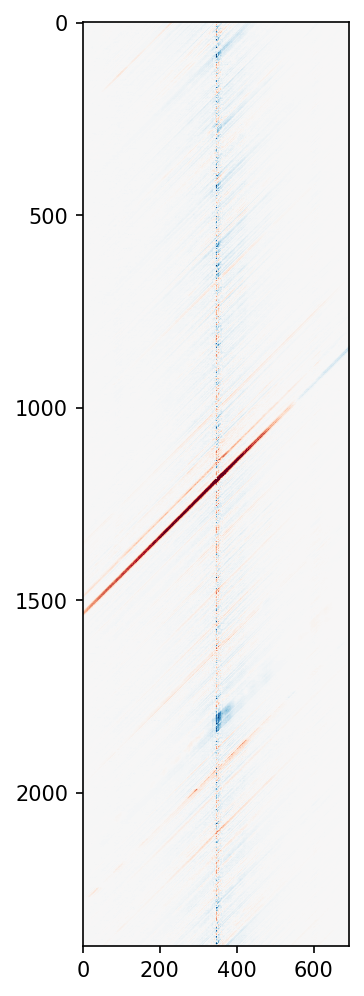

In [77]:
pisaSpan = 0.1
plt.imshow(pisaVals[:,700:-700], vmin=-pisaSpan, vmax=pisaSpan, cmap='RdBu_r')


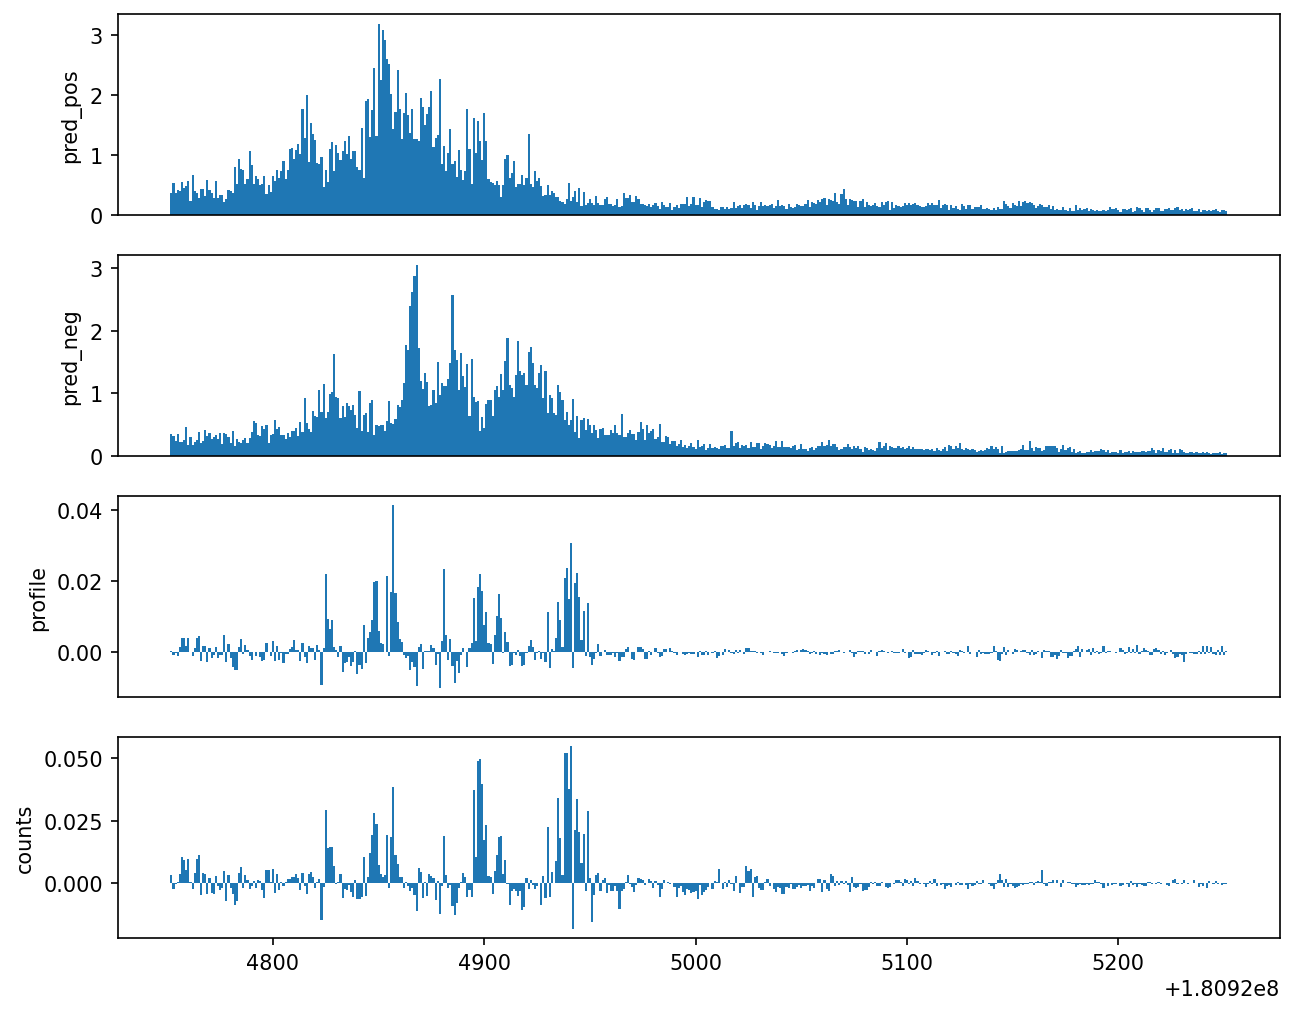

In [78]:
#Let's remind ourselves of what the nanog binding looked like...
plotShapBigwigs('nanog', 'residual', startPos = windowStart + 1000, span=500)

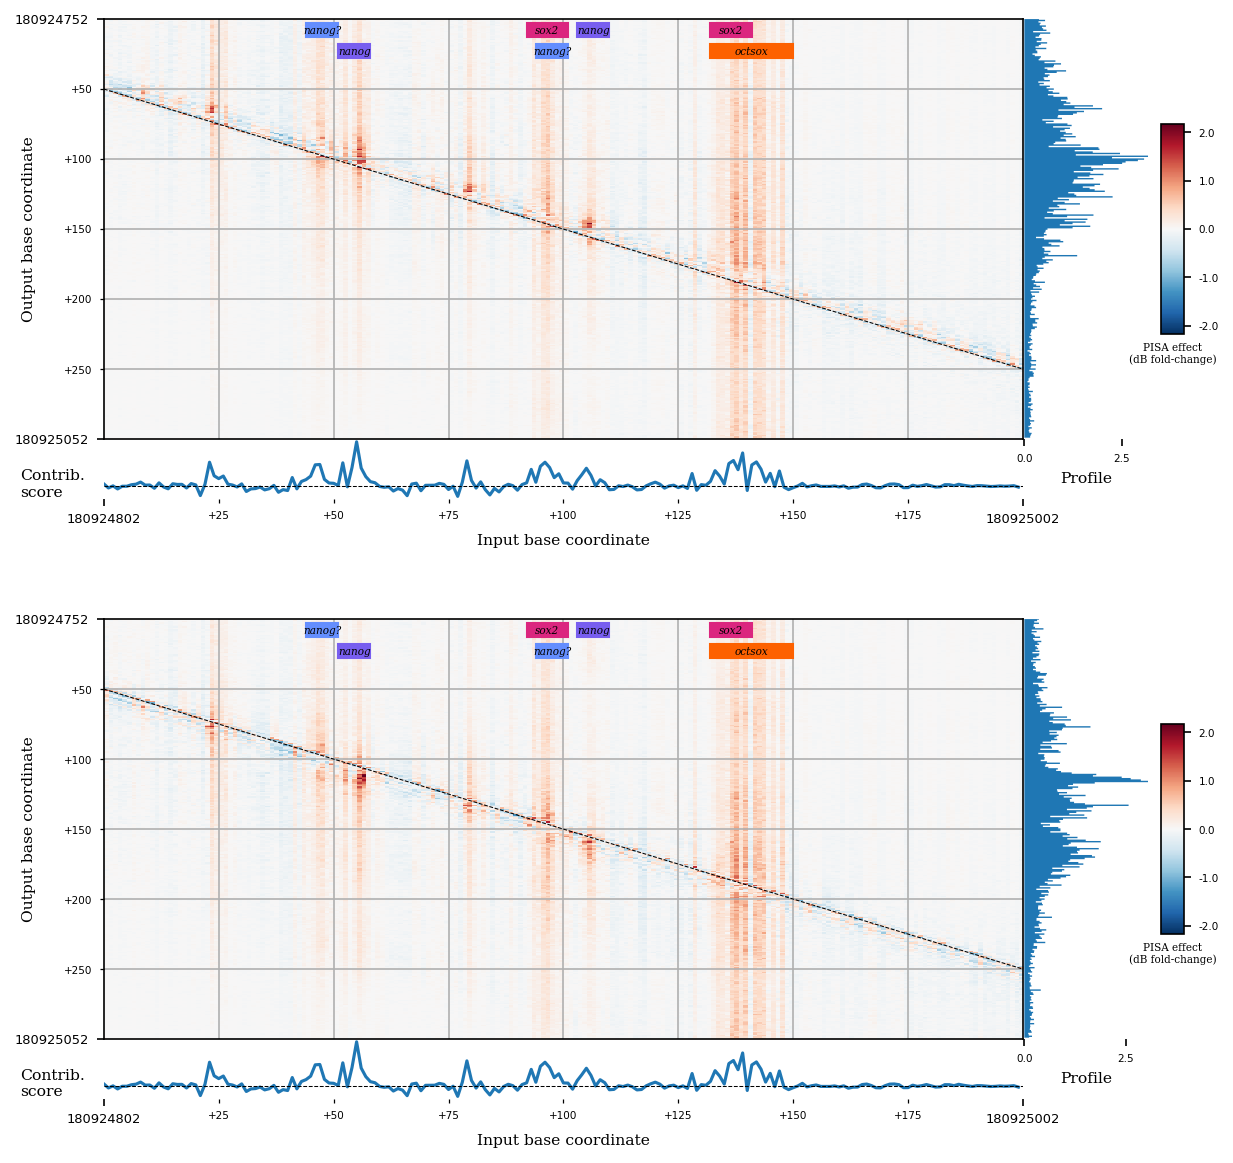

In [79]:
nameColors = dict()
fig = plt.figure()

bprplots.plotPisa(WORKING_DIRECTORY + "/shap/pisa_nanog_positive.h5",
                  1150, 200, 300, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/nanog_profile.bw",
                  WORKING_DIRECTORY + "/scan/nanog_profile.bed",
                  WORKING_DIRECTORY + "/pred/nanog_residual_positive.bw",
                  nameColors,
                  fig, [0.1, 0.55, 0.9, 0.4],
                  colorSpan = 0.5,
                  fontsize=5)

bprplots.plotPisa(WORKING_DIRECTORY + "/shap/pisa_nanog_negative.h5",
                  1150, 200, 300, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/nanog_profile.bw",
                  WORKING_DIRECTORY + "/scan/nanog_profile.bed",
                  WORKING_DIRECTORY + "/pred/nanog_residual_negative.bw",
                  nameColors,
                  fig, [0.1, 0.05, 0.9, 0.4],
                  colorSpan = 0.5);


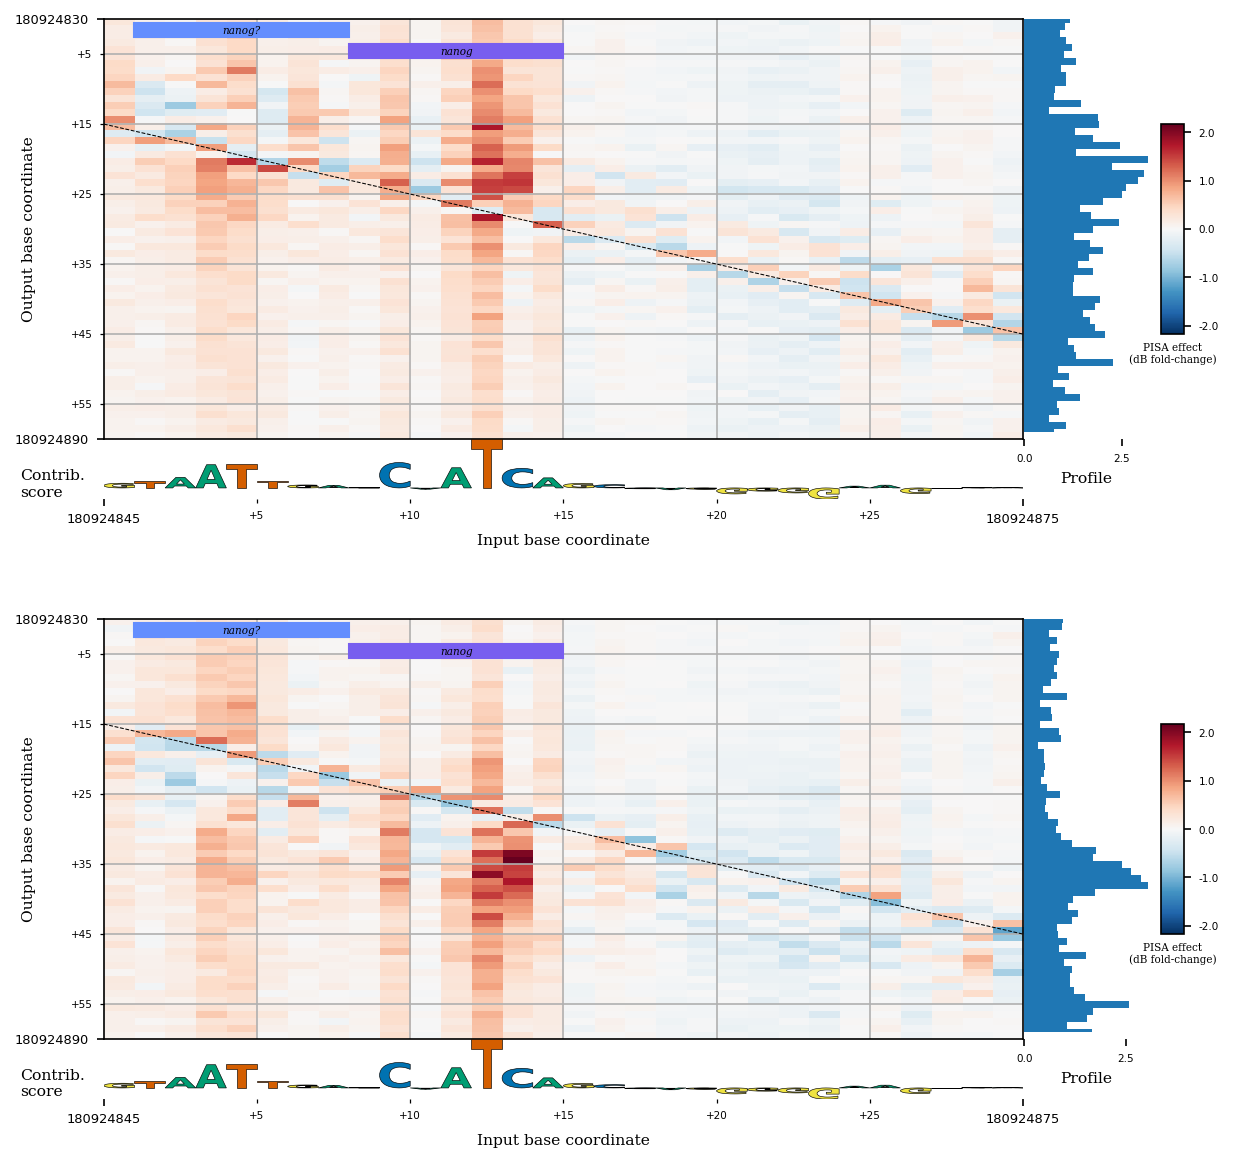

In [80]:
#One thing is pretty striking. The motif at ~100 bp has a directional effect, that is, the importance toward the positive peak is upstream of the 
#motif and the importance of the negative peak is downstream. But the motif at ~190 doesn't seem to be directional, and it seems to have a larger 
#reach. Let's zoom in! 
fig = plt.figure()

bprplots.plotPisa(WORKING_DIRECTORY + "/shap/pisa_nanog_positive.h5",
                  1108, 30, 60, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/nanog_profile.bw",
                  WORKING_DIRECTORY + "/scan/nanog_profile.bed",
                  WORKING_DIRECTORY + "/pred/nanog_residual_positive.bw",
                  nameColors,
                  fig, [0.1, 0.55, 0.9, 0.4],
                  colorSpan = 0.5)

bprplots.plotPisa(WORKING_DIRECTORY + "/shap/pisa_nanog_negative.h5",
                  1108, 30, 60, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/nanog_profile.bw",
                  WORKING_DIRECTORY + "/scan/nanog_profile.bed",
                  WORKING_DIRECTORY + "/pred/nanog_residual_negative.bw",
                  nameColors,
                  fig, [0.1, 0.05, 0.9, 0.4],
                  colorSpan = 0.5);


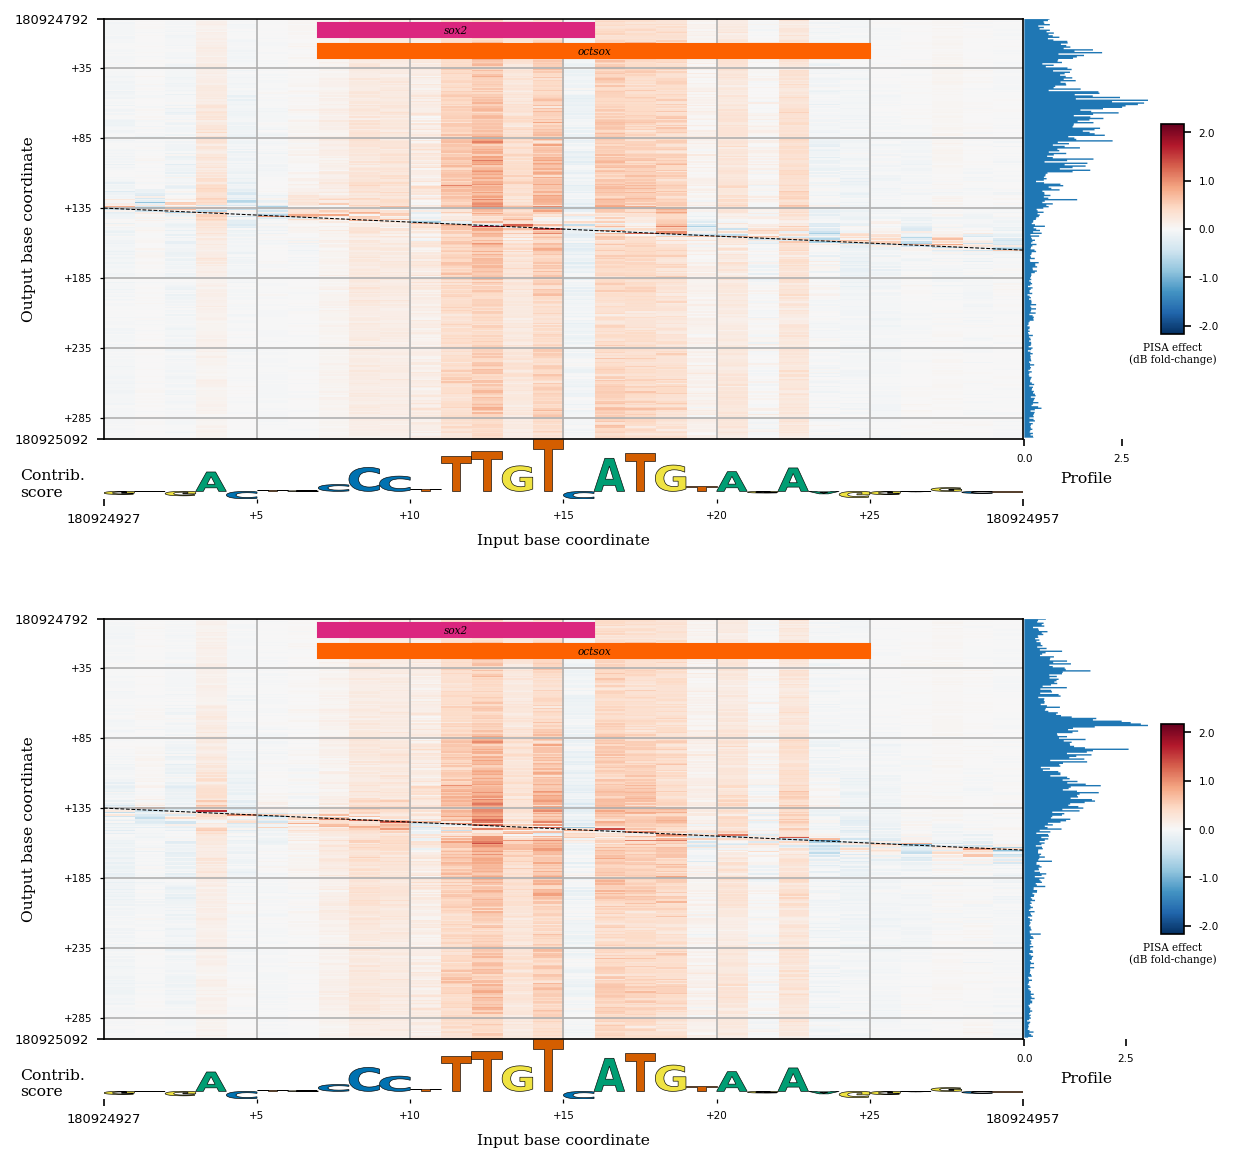

In [81]:
fig = plt.figure()

bprplots.plotPisa(WORKING_DIRECTORY + "/shap/pisa_nanog_positive.h5",
                  1190, 30, 300, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/nanog_profile.bw",
                  WORKING_DIRECTORY + "/scan/nanog_profile.bed",
                  WORKING_DIRECTORY + "/pred/nanog_residual_positive.bw",
                  nameColors,
                  fig, [0.1, 0.55, 0.9, 0.4],
                  colorSpan = 0.5)

bprplots.plotPisa(WORKING_DIRECTORY + "/shap/pisa_nanog_negative.h5",
                  1190, 30, 300, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/nanog_profile.bw",
                  WORKING_DIRECTORY + "/scan/nanog_profile.bed",
                  WORKING_DIRECTORY + "/pred/nanog_residual_negative.bw",
                  nameColors,
                  fig, [0.1, 0.05, 0.9, 0.4],
                  colorSpan = 0.5);


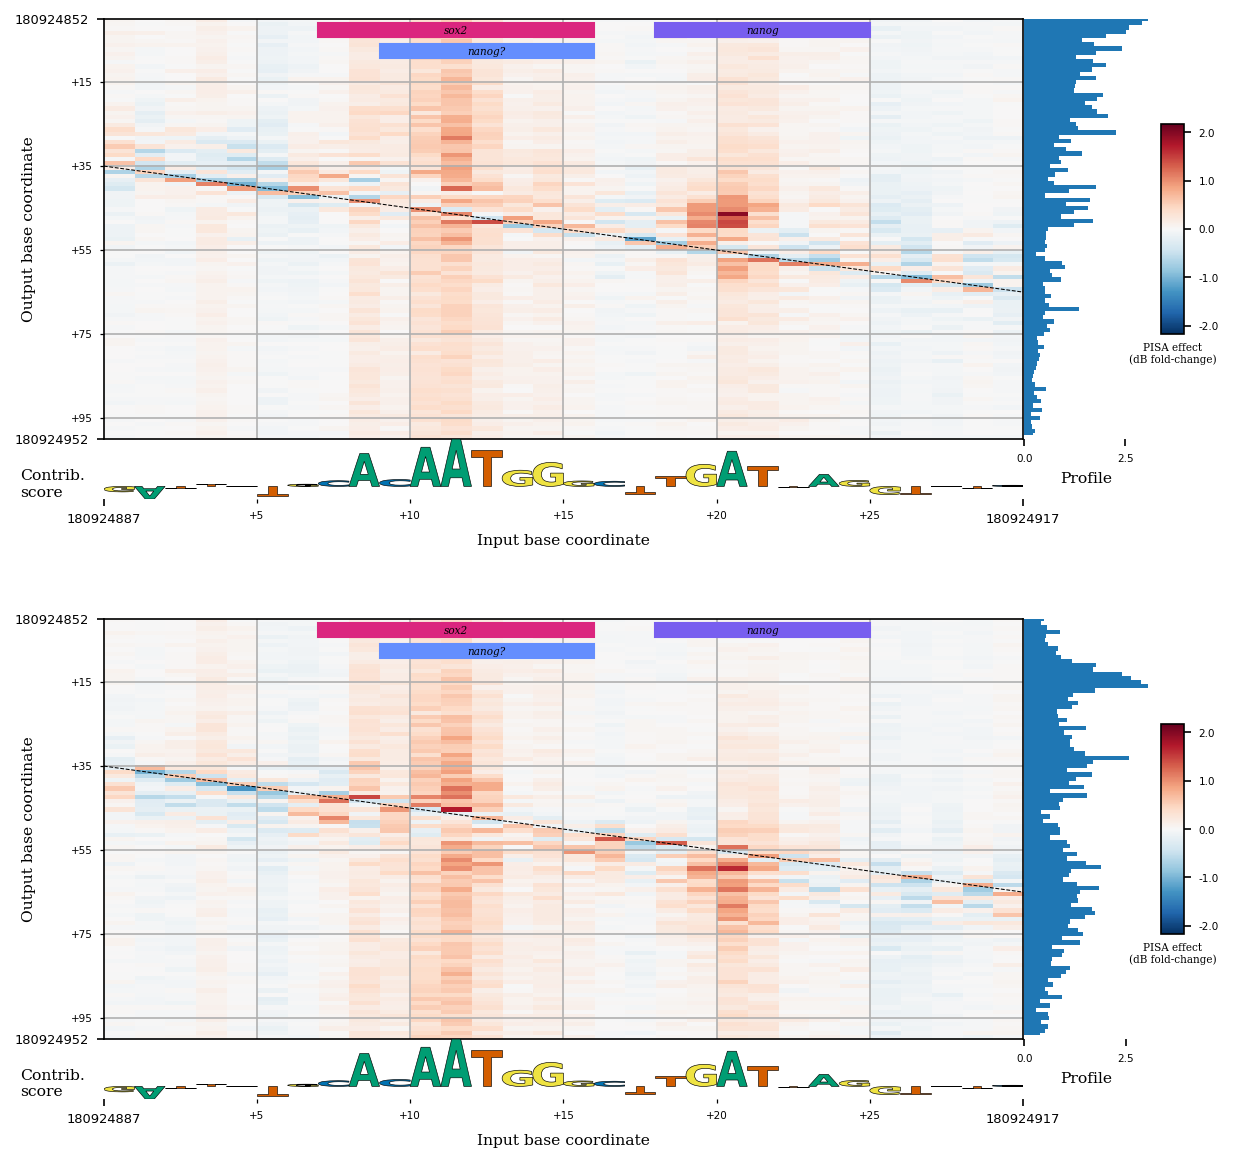

In [82]:
fig = plt.figure()

bprplots.plotPisa(WORKING_DIRECTORY + "/shap/pisa_nanog_positive.h5",
                  1150, 30, 100, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/nanog_profile.bw",
                  WORKING_DIRECTORY + "/scan/nanog_profile.bed",
                  WORKING_DIRECTORY + "/pred/nanog_residual_positive.bw",
                  nameColors,
                  fig, [0.1, 0.55, 0.9, 0.4],
                  colorSpan = 0.5)

bprplots.plotPisa(WORKING_DIRECTORY + "/shap/pisa_nanog_negative.h5",
                  1150, 30, 100, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/nanog_profile.bw",
                  WORKING_DIRECTORY + "/scan/nanog_profile.bed",
                  WORKING_DIRECTORY + "/pred/nanog_residual_negative.bw",
                  nameColors,
                  fig, [0.1, 0.05, 0.9, 0.4],
                  colorSpan = 0.5);

In [83]:
#Indeed, this motif looks very different! 

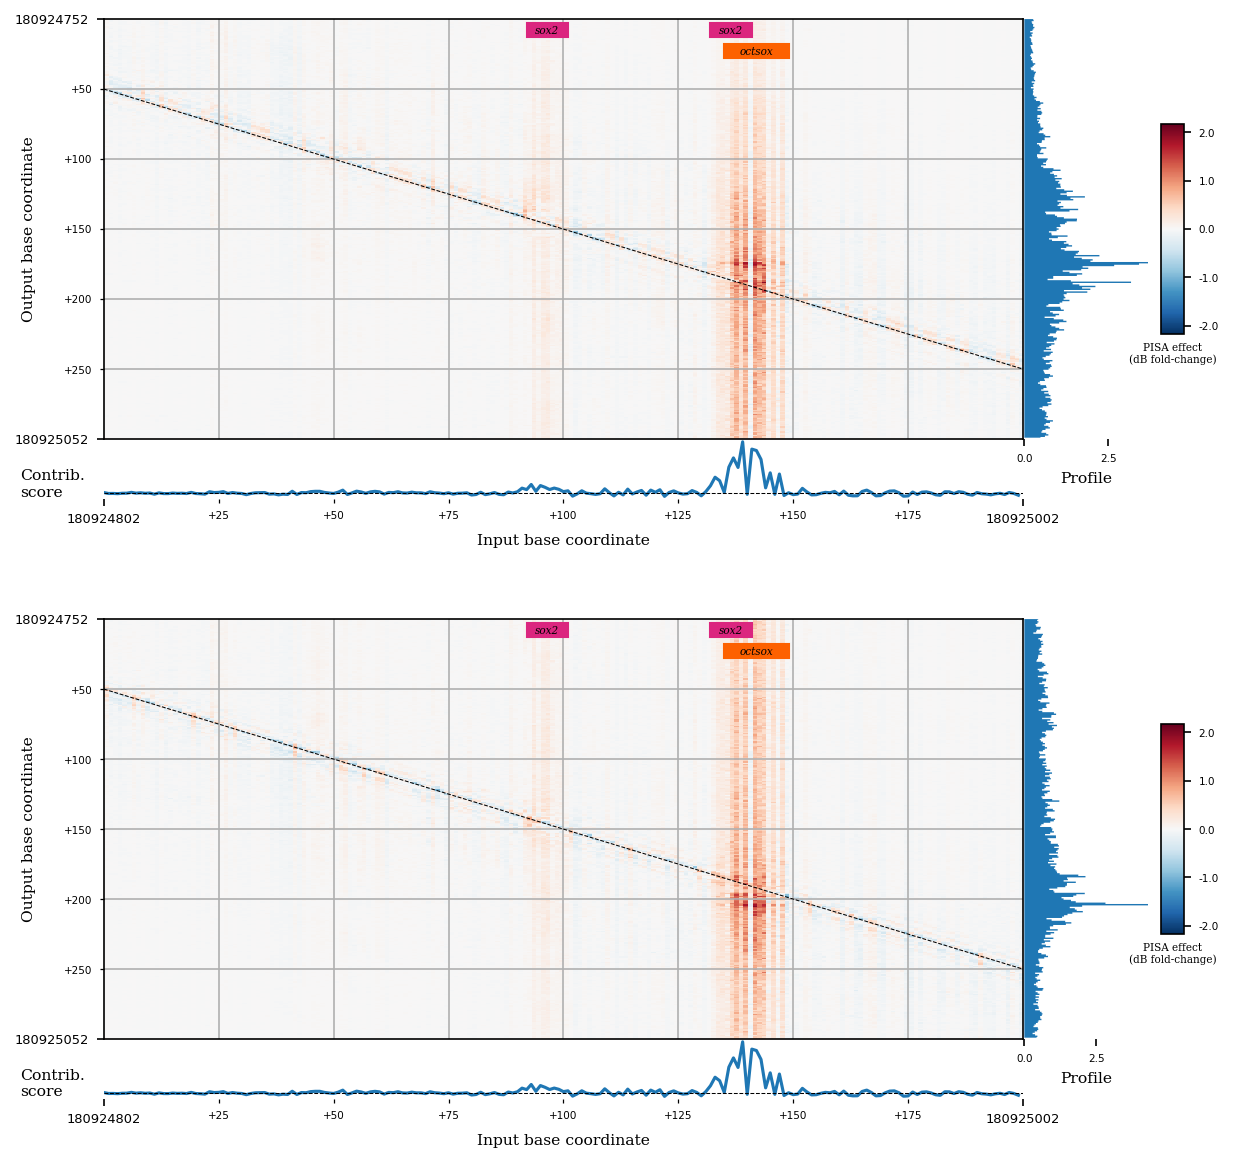

In [84]:
fig = plt.figure()

bprplots.plotPisa(WORKING_DIRECTORY + "/shap/pisa_oct4_positive.h5",
                  1150, 200, 300, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/oct4_profile.bw",
                  WORKING_DIRECTORY + "/scan/oct4_profile.bed",
                  WORKING_DIRECTORY + "/pred/oct4_residual_positive.bw",
                  nameColors,
                  fig, [0.1, 0.55, 0.9, 0.4],
                  colorSpan = 0.5)

bprplots.plotPisa(WORKING_DIRECTORY + "/shap/pisa_oct4_negative.h5",
                  1150, 200, 300, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/oct4_profile.bw",
                  WORKING_DIRECTORY + "/scan/oct4_profile.bed",
                  WORKING_DIRECTORY + "/pred/oct4_residual_negative.bw",
                  nameColors,
                  fig, [0.1, 0.05, 0.9, 0.4],
                  colorSpan = 0.5);


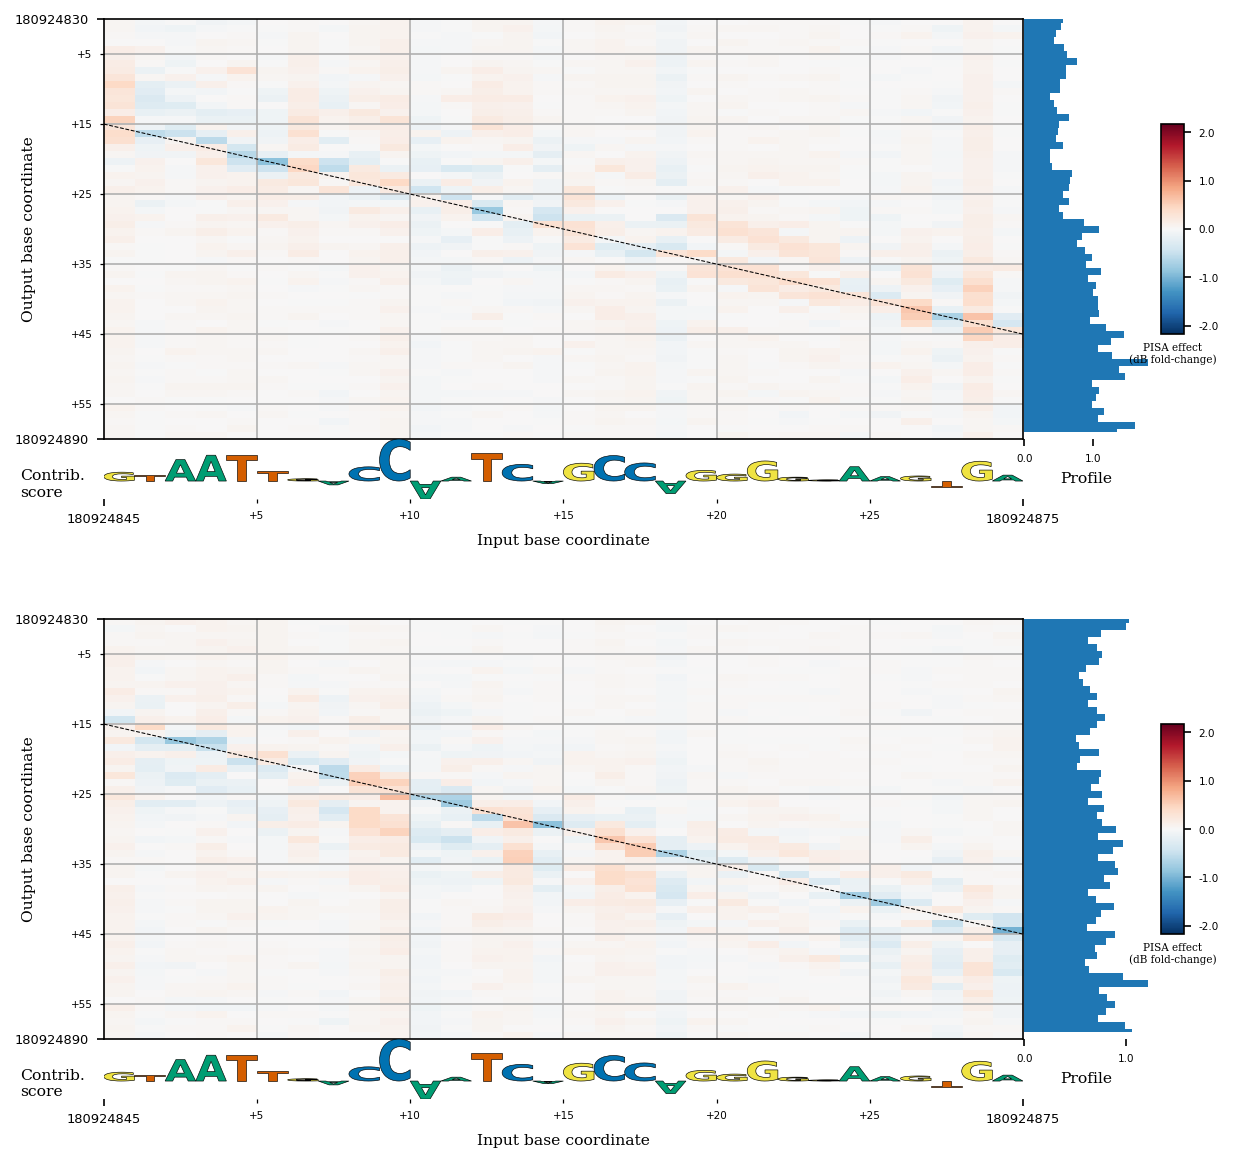

In [85]:
fig = plt.figure()

bprplots.plotPisa(WORKING_DIRECTORY + "/shap/pisa_oct4_positive.h5",
                  1108, 30, 60, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/oct4_profile.bw",
                  WORKING_DIRECTORY + "/scan/oct4_profile.bed",
                  WORKING_DIRECTORY + "/pred/oct4_residual_positive.bw",
                  nameColors,
                  fig, [0.1, 0.55, 0.9, 0.4],
                  colorSpan = 0.5)

bprplots.plotPisa(WORKING_DIRECTORY + "/shap/pisa_oct4_negative.h5",
                  1108, 30, 60, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/oct4_profile.bw",
                  WORKING_DIRECTORY + "/scan/oct4_profile.bed",
                  WORKING_DIRECTORY + "/pred/oct4_residual_negative.bw",
                  nameColors,
                  fig, [0.1, 0.05, 0.9, 0.4],
                  colorSpan = 0.5);



In [86]:
#Ah, that might explain why the motif acts differently - it's a motif for a different protein altogether! Let's zoom in on the Oct4 motif. 

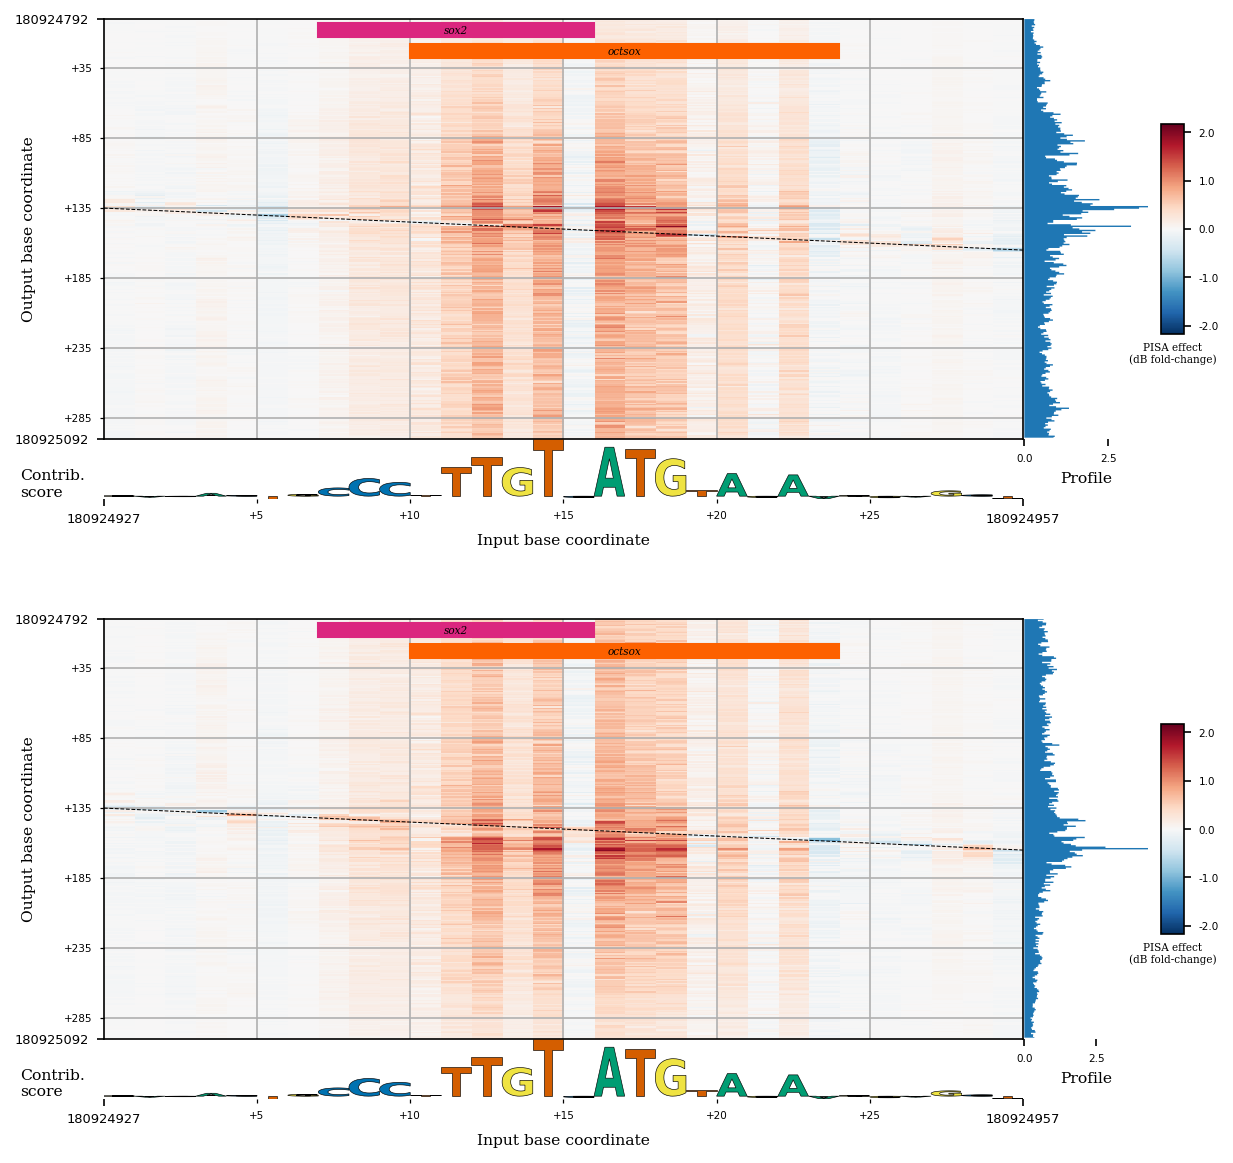

In [87]:
fig = plt.figure()

bprplots.plotPisa(WORKING_DIRECTORY + "/shap/pisa_oct4_positive.h5",
                  1190, 30, 300, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/oct4_profile.bw",
                  WORKING_DIRECTORY + "/scan/oct4_profile.bed",
                  WORKING_DIRECTORY + "/pred/oct4_residual_positive.bw",
                  nameColors,
                  fig, [0.1, 0.55, 0.9, 0.4],
                  colorSpan = 0.5)

bprplots.plotPisa(WORKING_DIRECTORY + "/shap/pisa_oct4_negative.h5",
                  1190, 30, 300, RECEPTIVE_FIELD,
                  windowStart, "chr1", GENOME_FASTA,
                  WORKING_DIRECTORY + "/shap/oct4_profile.bw",
                  WORKING_DIRECTORY + "/scan/oct4_profile.bed",
                  WORKING_DIRECTORY + "/pred/oct4_residual_negative.bw",
                  nameColors,
                  fig, [0.1, 0.05, 0.9, 0.4],
                  colorSpan = 0.5);



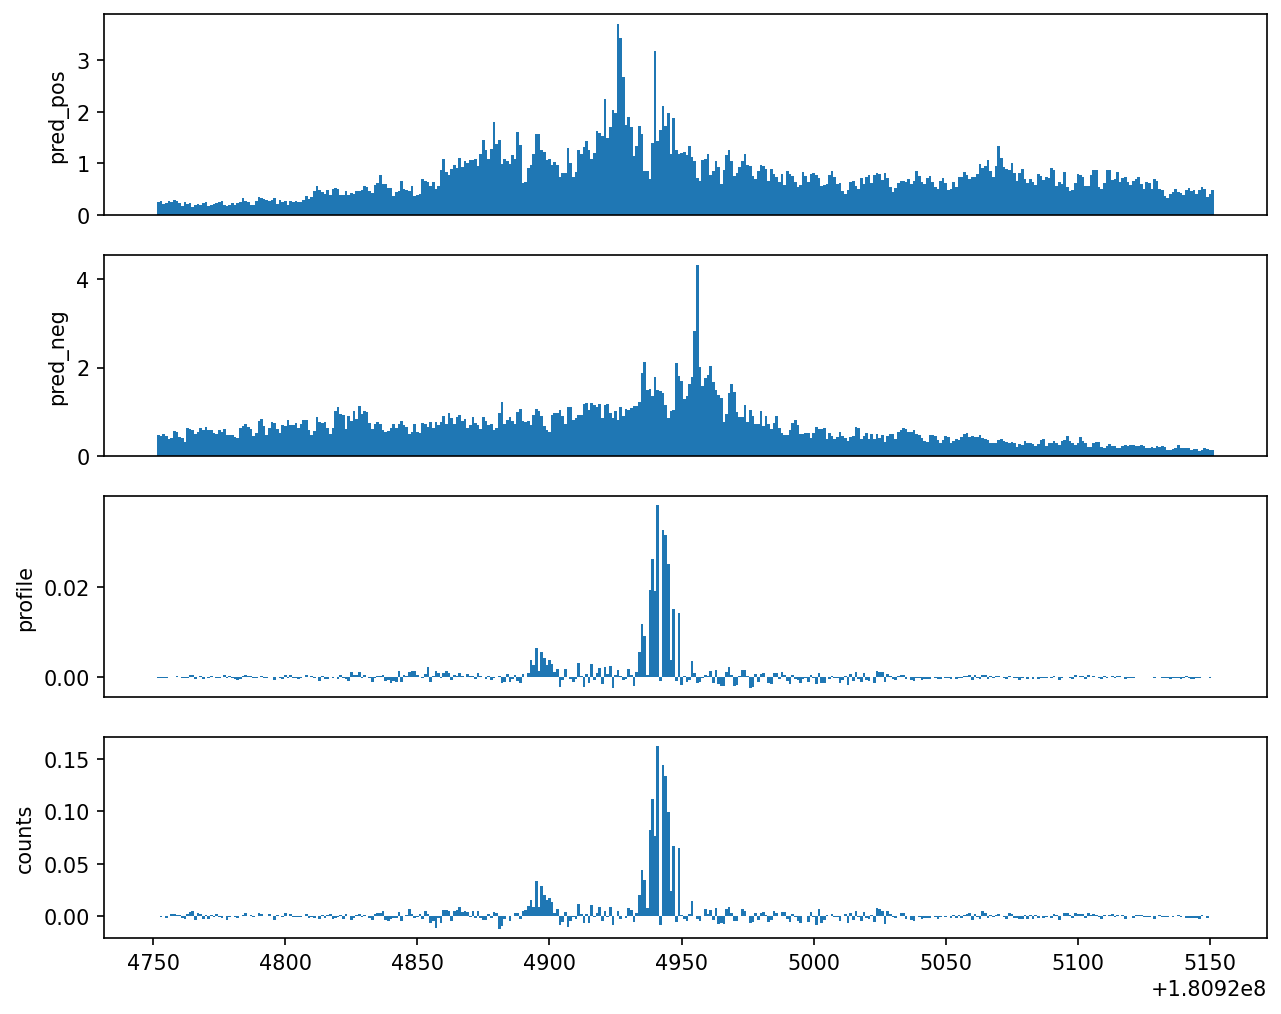

In [88]:
#As a reminder, let me pull up the Oct4 tracks:
plotShapBigwigs('oct4', 'residual', startPos = 180924752, span=400)